# Code for Random Sampling of Rewrites

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import json
# import random
# import os
# import re

# def create_latex_tables_from_samples(file_paths, num_samples=10, max_text_length=100):
#     def load_json_lines(file_path):
#         with open(file_path, 'r') as file:
#             return [json.loads(line) for line in file]

#     def find_armo_rm_key(item):
#         return next((key for key in item.keys() if 'ArmoRM' in key), None)

#     def truncate_text(text, max_length):
#         return text[:max_length] + '...' if len(text) > max_length else text

#     def escape_latex(text):
#         latex_special_chars = {'&': r'\&', '%': r'\%', '$': r'\$', '#': r'\#', '_': r'\_', '{': r'\{', '}': r'\}', '~': r'\textasciitilde{}', '^': r'\^{}', '\\': r'\textbackslash{}'}
#         return ''.join(latex_special_chars.get(c, c) for c in text)

#     def format_reward(reward):
#         return f"{reward:.5f}" if isinstance(reward, (int, float)) else reward

#     def get_descriptive_title(file_name):
#         # Extract database and concept from file name
#         match = re.match(r'(\w+)_(\w+)_', file_name)
#         if match:
#             database, concept = match.groups()
#             database = database.upper() if database.lower() == 'eli5' else database.capitalize()
#             return f"{database}, {concept.capitalize()}"
#         return file_name  # Fallback to filename if pattern doesn't match

#     def create_table(data, file_name):
#         title = get_descriptive_title(file_name)
#         latex_table = f"\\subsection*{{{title}}}\n"
#         latex_table += r"\begin{tabular}{|p{0.22\textwidth}|p{0.22\textwidth}|p{0.22\textwidth}|p{0.22\textwidth}|}\hline" + "\n"
#         latex_table += r"Original & Rewrite & Rewrite of Rewrite & Reward \\ \hline" + "\n"

#         for item in data:
#             w_original = item.get('w_original', False)
#             original = escape_latex(truncate_text(item['completions'].get('original', 'N/A'), max_text_length))
#             rewrite = escape_latex(truncate_text(item['completions'].get('rewrite', 'N/A'), max_text_length))
#             rewrite_of_rewrite = escape_latex(truncate_text(item['completions'].get('rewritten rewrite', 'N/A'), max_text_length))
            
#             armo_rm_key = find_armo_rm_key(item)
#             if armo_rm_key:
#                 reward_original = format_reward(item[armo_rm_key].get('original', 'N/A'))
#                 reward_rewrite = format_reward(item[armo_rm_key].get('rewrite', 'N/A'))
#                 reward_rewrite_of_rewrite = format_reward(item[armo_rm_key].get('rewritten rewrite', 'N/A'))
#             else:
#                 reward_original = reward_rewrite = reward_rewrite_of_rewrite = 'N/A'

#             latex_table += f"{original} (W = {1 if w_original else 0}) & "
#             latex_table += f"{rewrite} (W = {0 if w_original else 1}) & "
#             latex_table += f"{rewrite_of_rewrite} & "
#             latex_table += f"({reward_original}, {reward_rewrite}, {reward_rewrite_of_rewrite}) \\\\ \\hline\n"

#         latex_table += r"\end{tabular}" + "\n\n"
#         return latex_table

#     all_tables = []
#     for file_path in file_paths:
#         data = load_json_lines(file_path)
#         samples = random.sample(data, num_samples)
#         file_name = os.path.basename(file_path)
#         table = create_table(samples, file_name)
#         all_tables.append(table)

#     return '\n'.join(all_tables)

# # Example usage:
# file_paths = [
#     "eli5_length_complete_scored_20240919_170111.jsonl",
#     "hh_rlhf_sentiment_scored_complete.jsonl",
#     "imdb_sentiment_complete_scored_20240919_152739.jsonl",
#     "helpsteer_complexity_complete_scored.jsonl",
#     "helpsteer_helpfulness_complete_scored.jsonl"
# ]

# # latex_tables = create_latex_tables_from_samples(file_paths, max_text_length=100)
# # print(latex_tables)

# Plotting Functions

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from constants import SCORED_DIR
from treatment_effects import calculate_treatment_effects
from utils_plotting import rewrite_bias, naive_vs_RATE, synthetic, synthetic_3way, att_atu, synthetic_subplots
from utils import load_dataset_from_json, write_to_json
import warnings
warnings.filterwarnings('ignore')

In [4]:
experiment_templates = [
    {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    },
    {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    },
    {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "imdb_sentiment_complete_scored_20240919_152739.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Sentiment",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "imdb_sentiment_complete_scored_20240919_152739.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Sentiment",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "imdb_sentiment_complete_scored_20240919_152739.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Complexity",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "helpsteer_complexity_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Complexity",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "helpsteer_complexity_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Complexity",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "helpsteer_complexity_complete_scored.jsonl"
    },        
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "helpsteer_helpfulness_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "helpsteer_helpfulness_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "helpsteer_helpfulness_complete_scored.jsonl"
    },
    {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    },
    {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    },
    {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl",
        "original": "rewritten rewrite",
        "rewrite": "rewrite"
    }
]

In [5]:
# save all the data
effects_data = []
for effects_template in experiment_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "complete" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    effects_data.append(effects)

2024-10-02 00:08:17,063 - INFO - Number of w=1 examples: 12612
2024-10-02 00:08:17,063 - INFO - Number of w=0 examples: 12389
2024-10-02 00:08:17,112 - INFO - Treatment effects: {   'ATE': -0.0008267120345947232,
    'ATE_naive': 0.001494292597008548,
    'ATE_stderr': 6.802260984332354e-05,
    'ATE_stderr_naive': 9.391197021986063e-05,
    'ATT': 0.0005248629986794456,
    'ATT_naive': -0.002639021079802975,
    'ATT_stderr': 0.0003215778627196273,
    'ATT_stderr_naive': 0.000316398091089196,
    'ATU': -0.002202615200278285,
    'ATU_naive': 0.00570200525274725,
    'ATU_stderr': 0.0003354240091955926,
    'ATU_stderr_naive': 0.0003233334507112074,
    'naive_effect': 0.0033786455857264808,
    'naive_effect_naive': 0.008119381960269595,
    'naive_effect_stderr': 0.0003303620560513964,
    'naive_effect_stderr_naive': 0.0003128414498368806}
2024-10-02 00:08:17,113 - INFO - Calculated ATE (from ATT and ATU): -0.0008267120345947166
2024-10-02 00:08:17,126 - INFO - Rewrite effects: {

In [6]:
effects_data[0]

{'ATE': -0.0008267120345947232,
 'ATE_stderr': 6.802260984332354e-05,
 'ATT': 0.0005248629986794456,
 'ATT_stderr': 0.0003215778627196273,
 'ATU': -0.002202615200278285,
 'ATU_stderr': 0.0003354240091955926,
 'naive_effect': 0.0033786455857264808,
 'naive_effect_stderr': 0.0003303620560513964,
 'ATE_naive': 0.001494292597008548,
 'ATE_stderr_naive': 9.391197021986063e-05,
 'ATT_naive': -0.002639021079802975,
 'ATT_stderr_naive': 0.000316398091089196,
 'ATU_naive': 0.00570200525274725,
 'ATU_stderr_naive': 0.0003233334507112074,
 'naive_effect_naive': 0.008119381960269595,
 'naive_effect_stderr_naive': 0.0003128414498368806,
 'rewrite_effect_w_1': 0.0031638840784824133,
 'rewrite_effect_w_1_stderr': 0.0001460974493370488,
 'rewrite_effect_w_0': 0.007904620453025533,
 'rewrite_effect_w_0_stderr': 0.00014441465293849764,
 'reward_std': 0.02655430901757349,
 'Y1_count': 12612,
 'Y0_count': 12389,
 'ATT_corrected': 0.008429483451704979,
 'ATT_corrected_stderr': 0.00046599251565812496,
 'ATU

In [7]:
# my_template = {
#         "dataset_name": "HH-RLHF",
#         "concept": "Sentiment",
#         "score": "ArmoRM",
#         "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
#         "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
#     }

# dataset_filename = my_template["dataset_filename"]
# dataset_filename = Path(dataset_filename)
# hh_rlhf_scores = load_dataset_from_json(SCORED_DIR / "complete" / dataset_filename)
# hh_rlhf_scores


# # Extract ArmoRM scores from raw_data
# hh_rlhf_armoRM_original_scores = []
# hh_rlhf_armoRM_rewrite_rewrite_scores = []

# for key, data_point in hh_rlhf_scores.items():
#     hh_rlhf_armoRM_original_scores.append(data_point['RLHFlow/ArmoRM-Llama3-8B-v0.1']['original'])
#     hh_rlhf_armoRM_rewrite_rewrite_scores.append(data_point['RLHFlow/ArmoRM-Llama3-8B-v0.1']['rewritten rewrite'])

# my_template = {
#         "dataset_name": "ELI5",
#         "concept": "Length",
#         "score": "ArmoRM",
#         "reward_key": "ArmoRM",
#         "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
#     }

# dataset_filename = my_template["dataset_filename"]
# dataset_filename = Path(dataset_filename)
# eli5_scores = load_dataset_from_json(SCORED_DIR / "complete" / dataset_filename)
# eli5_scores


# # Extract ArmoRM scores from raw_data
# eli5_armoRM_original_scores = []
# eli5_armoRM_rewrite_rewrite_scores = []

# for key, data_point in eli5_scores.items():
#     eli5_armoRM_original_scores.append(data_point['ArmoRM']['original'])
#     eli5_armoRM_rewrite_rewrite_scores.append(data_point['ArmoRM']['rewritten rewrite'])

In [8]:
# def process_dataset(template, w_original):
#     dataset_filename = Path(template["dataset_filename"])
#     scores = load_dataset_from_json(SCORED_DIR / "complete" / dataset_filename)
    
#     original_scores = []
#     rewrite_scores = []
    
#     for key, data_point in scores.items():
#         if data_point['w_original'] == w_original:
#             original_scores.append(data_point[template['reward_key']]['original'])
#             rewrite_scores.append(data_point[template['reward_key']]['rewritten rewrite'])
    
#     # if template['dataset_name'] == "ELI5":
#     #     original_scores = list((np.array(original_scores) - np.mean(original_scores))/effects_data[0]['reward_std'])
#     #     rewrite_scores = list((np.array(rewrite_scores) - np.mean(original_scores))/effects_data[0]['reward_std'])
#     # else:
#     #     original_scores = list((np.array(original_scores) - np.mean(original_scores))/effects_data[-3]['reward_std'])
#     #     rewrite_scores = list((np.array(rewrite_scores) - np.mean(original_scores))/effects_data[-3]['reward_std'])
#     if template['dataset_name'] == "ELI5":
#         original_scores = list(np.array(original_scores))
#         rewrite_scores = list(np.array(rewrite_scores))
#     else:
#         original_scores = list(np.array(original_scores))
#         rewrite_scores = list(np.array(rewrite_scores))

#     return original_scores, rewrite_scores

# def create_plot(original_scores, rewrite_scores, title, ax, w_original):
#     colors = ["#1f77b4", "#ff7f0e"]
    
#     if original_scores:
#         sns.kdeplot(original_scores, label="Original", 
#                     color=colors[0], fill=True, alpha=0.5, linewidth=2, ax=ax)
#         original_mean = np.mean(original_scores)
#         ax.axvline(original_mean, color=colors[0], linestyle="--", linewidth=2)
    
#     sns.kdeplot(rewrite_scores, label="Rewrite of Rewrite", 
#                 color=colors[1], fill=True, alpha=0.5, linewidth=2, ax=ax)
#     rewrite_mean = np.mean(rewrite_scores)
#     ax.axvline(rewrite_mean, color=colors[1], linestyle="--", linewidth=2)
    
#     ax.set_title(f"{title} ArmoRM Rewards\nConditional on W = {int(w_original)}", fontsize=16, fontweight='bold', pad=20)
#     ax.set_xlabel("Reward", fontsize=12)
#     ax.set_ylabel("Density", fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    
#     legend_elements = []
#     if original_scores:
#         legend_elements.append(Line2D([0], [0], color=colors[0], linewidth=2, label="Original"))
#     legend_elements.append(Line2D([0], [0], color=colors[1], linewidth=2, label="Rewrite of Rewrite"))
#     legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="Mean"))
    
#     ax.legend(handles=legend_elements, 
#               title="Score Type", title_fontsize='12', fontsize=10, frameon=True, fancybox=True, shadow=True)

# hh_rlhf_template = {
#     "dataset_name": "HH-RLHF",
#     "concept": "Sentiment",
#     "score": "ArmoRM",
#     "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
#     "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
# }

# eli5_template = {
#     "dataset_name": "ELI5",
#     "concept": "Length",
#     "score": "ArmoRM",
#     "reward_key": "ArmoRM",
#     "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
# }

# sns.set_theme(style="whitegrid", font="serif")
# fig, axs = plt.subplots(2, 2, figsize=(16, 8), dpi=300)

# for i, w_original in enumerate([True, False]):
#     hh_rlhf_original, hh_rlhf_rewrite = process_dataset(hh_rlhf_template, w_original)
#     eli5_original, eli5_rewrite = process_dataset(eli5_template, w_original)
    
#     create_plot(hh_rlhf_original, hh_rlhf_rewrite, "HH-RLHF", axs[i, 0], w_original)
#     create_plot(eli5_original, eli5_rewrite, "ELI5", axs[i, 1], w_original)

# plt.tight_layout()
# plt.show()


In [9]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.lines import Line2D

# # Set the style to a more academic look
# sns.set_theme(style="whitegrid", font="serif")

# # Calculate the means for HH-RLHF and ELI5 scores
# hh_rlhf_original_mean = np.mean(hh_rlhf_armoRM_original_scores)
# hh_rlhf_rewrite_mean = np.mean(hh_rlhf_armoRM_rewrite_rewrite_scores)
# eli5_original_mean = np.mean(eli5_armoRM_original_scores)
# eli5_rewrite_mean = np.mean(eli5_armoRM_rewrite_rewrite_scores)

# # Create the figure with two subplots, with a more horizontal layout
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), dpi=300)

# # Define a more professional color palette
# colors = ["#1f77b4", "#ff7f0e"]

# # KDE plot for HH-RLHF scores (first subplot)
# sns.kdeplot(hh_rlhf_armoRM_original_scores, label="Original", 
#             color=colors[0], fill=True, alpha=0.5, linewidth=2, ax=ax1)
# sns.kdeplot(hh_rlhf_armoRM_rewrite_rewrite_scores, label="Rewritten", 
#             color=colors[1], fill=True, alpha=0.5, linewidth=2, ax=ax1)

# # Plot the means for HH-RLHF scores (colored lines)
# ax1.axvline(hh_rlhf_original_mean, color=colors[0], linestyle="--", linewidth=2)
# ax1.axvline(hh_rlhf_rewrite_mean, color=colors[1], linestyle="--", linewidth=2)

# # Set titles and labels for the first subplot
# ax1.set_title("HH-RLHF ArmoRM Rewards", fontsize=20, fontweight='bold', pad=20)
# ax1.set_xlabel("Reward", fontsize=12)
# ax1.set_ylabel("Density", fontsize=12)
# ax1.tick_params(axis='both', which='major', labelsize=10)
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)

# # KDE plot for ELI5 scores (second subplot)
# sns.kdeplot(eli5_armoRM_original_scores, label="Original", 
#             color=colors[0], fill=True, alpha=0.5, linewidth=2, ax=ax2)
# sns.kdeplot(eli5_armoRM_rewrite_rewrite_scores, label="Rewritten", 
#             color=colors[1], fill=True, alpha=0.5, linewidth=2, ax=ax2)

# # Plot the means for ELI5 scores (colored lines)
# ax2.axvline(eli5_original_mean, color=colors[0], linestyle="--", linewidth=2)
# ax2.axvline(eli5_rewrite_mean, color=colors[1], linestyle="--", linewidth=2)

# # Set titles and labels for the second subplot
# ax2.set_title("ELI5 ArmoRM Rewards", fontsize=20, fontweight='bold', pad=20)
# ax2.set_xlabel("Reward", fontsize=12)
# ax2.set_ylabel("Density", fontsize=12)
# ax2.tick_params(axis='both', which='major', labelsize=10)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)

# # Create a custom legend entry for the mean lines (colorless in the legend)
# mean_legend = Line2D([0], [0], color="black", linestyle="--", label="Mean")

# # Add the custom legend with KDE plot colors and the mean indicator
# ax1.legend(handles=[Line2D([0], [0], color=colors[0], linewidth=2, label="Original"),
#                     Line2D([0], [0], color=colors[1], linewidth=2, label="Rewrite of Rewrite"),
#                     mean_legend], 
#            title="Score Type", title_fontsize='14', fontsize=12, frameon=True, fancybox=True, shadow=True)

# ax2.legend(handles=[Line2D([0], [0], color=colors[0], linewidth=2, label="Original"),
#                     Line2D([0], [0], color=colors[1], linewidth=2, label="Rewrite of Rewrite"),
#                     mean_legend], 
#            title="Score Type", title_fontsize='14', fontsize=12, frameon=True, fancybox=True, shadow=True)

# # Adjust layout to avoid overlap
# plt.tight_layout()

# # Show the plot
# plt.show()

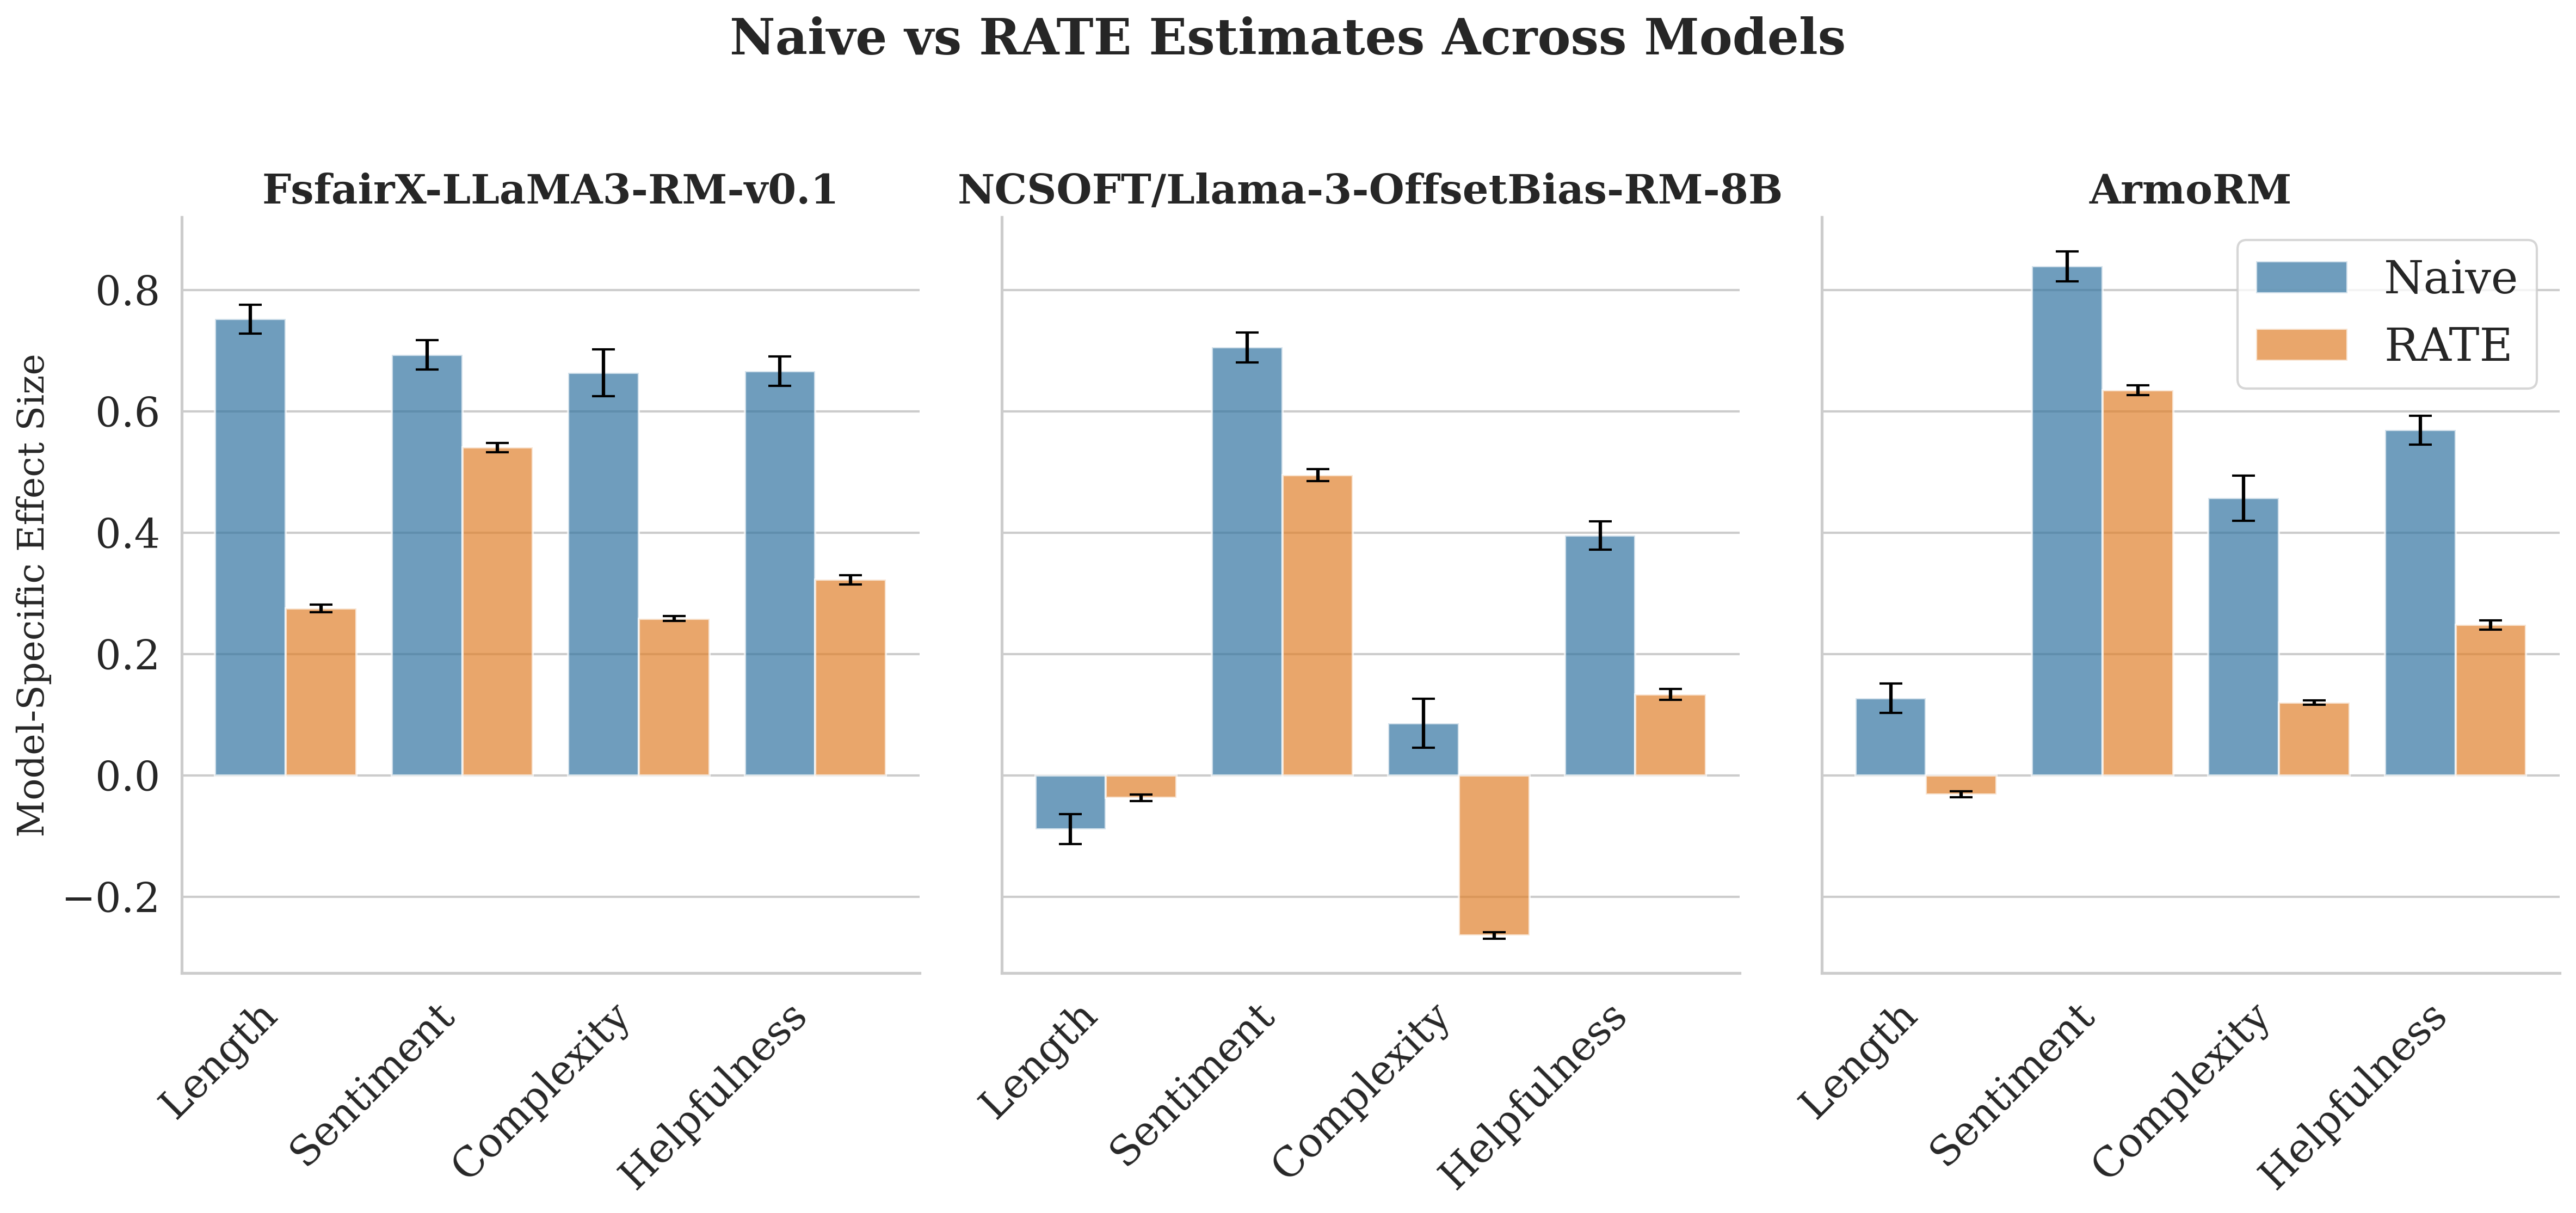

In [10]:
reward_models = ['FsfairX-LLaMA3-RM-v0.1', 'NCSOFT/Llama-3-OffsetBias-RM-8B', 'ArmoRM']
naive_vs_RATE(effects_data, experiment_templates, reward_models, normalize = 'reward_std')

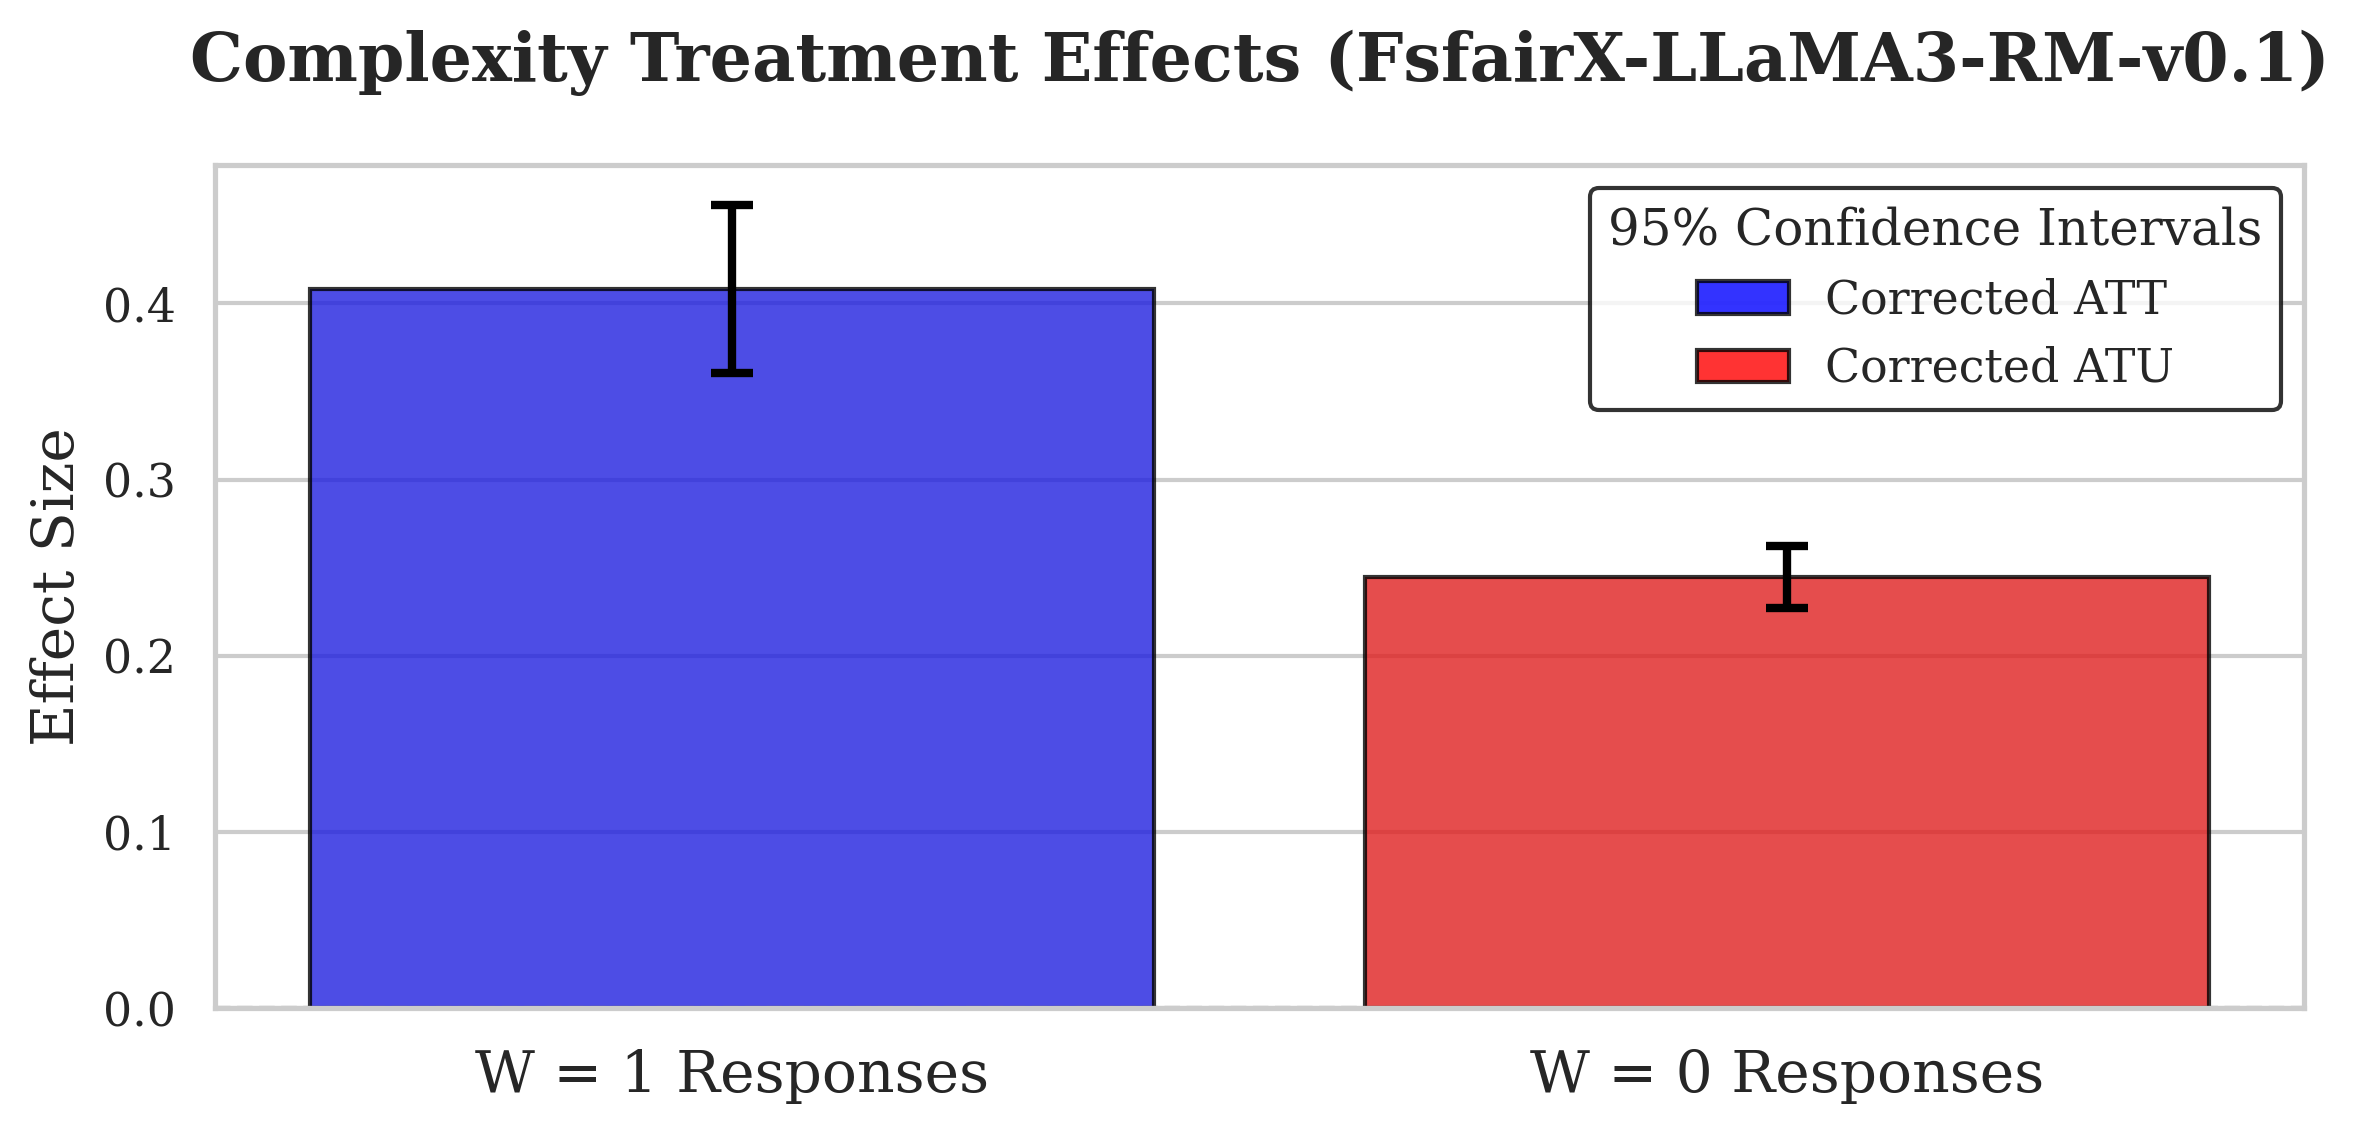

In [11]:
att_atu(effects_data[8], effects_data[8]['reward_std'])

2024-10-02 00:08:28,713 - INFO - Number of w=1 examples: 12612
2024-10-02 00:08:28,714 - INFO - Number of w=0 examples: 12389
2024-10-02 00:08:28,767 - INFO - Treatment effects: {   'ATE': 0.43088250377455584,
    'ATE_naive': 0.5060062783035555,
    'ATE_stderr': 0.0050337304417414274,
    'ATE_stderr_naive': 0.0065845849549471805,
    'ATT': 0.5996382834606617,
    'ATT_naive': 0.23633281200831213,
    'ATT_stderr': 0.018749159077815932,
    'ATT_stderr_naive': 0.01864015227159731,
    'ATU': 0.2590891472969421,
    'ATU_naive': 0.7805338234577732,
    'ATU_stderr': 0.018973828139292506,
    'ATU_stderr_naive': 0.018260335637600385,
    'naive_effect': 1.1765715413004019,
    'naive_effect_naive': 1.3347107460088834,
    'naive_effect_stderr': 0.019087766334155504,
    'naive_effect_stderr_naive': 0.018267480328409212}
2024-10-02 00:08:28,768 - INFO - Calculated ATE (from ATT and ATU): 0.4308825037745563
2024-10-02 00:08:28,782 - INFO - Rewrite effects: {   'rewrite_effect_w_0': 0.52

Calculating treatment effects for ELI5 dataset with sfairXC/FsfairX-LLaMA3-RM-v0.1 reward model...
Calculating treatment effects for ELI5 dataset with NCSOFT/Llama-3-OffsetBias-RM-8B reward model...
Calculating treatment effects for ELI5 dataset with ArmoRM reward model...


2024-10-02 00:08:28,945 - INFO - Treatment effects: {   'ATE': -0.0008267120345947232,
    'ATE_naive': 0.001494292597008548,
    'ATE_stderr': 6.802260984332354e-05,
    'ATE_stderr_naive': 9.391197021986063e-05,
    'ATT': 0.0005248629986794456,
    'ATT_naive': -0.002639021079802975,
    'ATT_stderr': 0.0003215778627196273,
    'ATT_stderr_naive': 0.000316398091089196,
    'ATU': -0.002202615200278285,
    'ATU_naive': 0.00570200525274725,
    'ATU_stderr': 0.0003354240091955926,
    'ATU_stderr_naive': 0.0003233334507112074,
    'naive_effect': 0.0033786455857264808,
    'naive_effect_naive': 0.008119381960269595,
    'naive_effect_stderr': 0.0003303620560513964,
    'naive_effect_stderr_naive': 0.0003128414498368806}
2024-10-02 00:08:28,946 - INFO - Calculated ATE (from ATT and ATU): -0.0008267120345947166
2024-10-02 00:08:28,960 - INFO - Rewrite effects: {   'rewrite_effect_w_0': 0.007904620453025533,
    'rewrite_effect_w_0_stderr': 0.00014441465293849764,
    'rewrite_effect_w_

{'ATE': 0.43088250377455584, 'ATE_stderr': 0.0050337304417414274, 'ATT': 0.5996382834606617, 'ATT_stderr': 0.018749159077815932, 'ATU': 0.2590891472969421, 'ATU_stderr': 0.018973828139292506, 'naive_effect': 1.1765715413004019, 'naive_effect_stderr': 0.019087766334155504, 'ATE_naive': 0.5060062783035555, 'ATE_stderr_naive': 0.0065845849549471805, 'ATT_naive': 0.23633281200831213, 'ATT_stderr_naive': 0.01864015227159731, 'ATU_naive': 0.7805338234577732, 'ATU_stderr_naive': 0.018260335637600385, 'naive_effect_naive': 1.3347107460088834, 'naive_effect_stderr_naive': 0.018267480328409212, 'rewrite_effect_w_1': 0.3633054714523494, 'rewrite_effect_w_1_stderr': 0.011107104890393555, 'rewrite_effect_w_0': 0.5214446761608317, 'rewrite_effect_w_0_stderr': 0.009880783306343661, 'reward_std': 1.564476644050067, 'Y1_count': 12612, 'Y0_count': 12389, 'ATT_corrected': 1.1210829596214933, 'ATT_corrected_stderr': 0.028629942384159595, 'ATU_corrected': -0.10421632415540732, 'ATU_corrected_stderr': 0.030

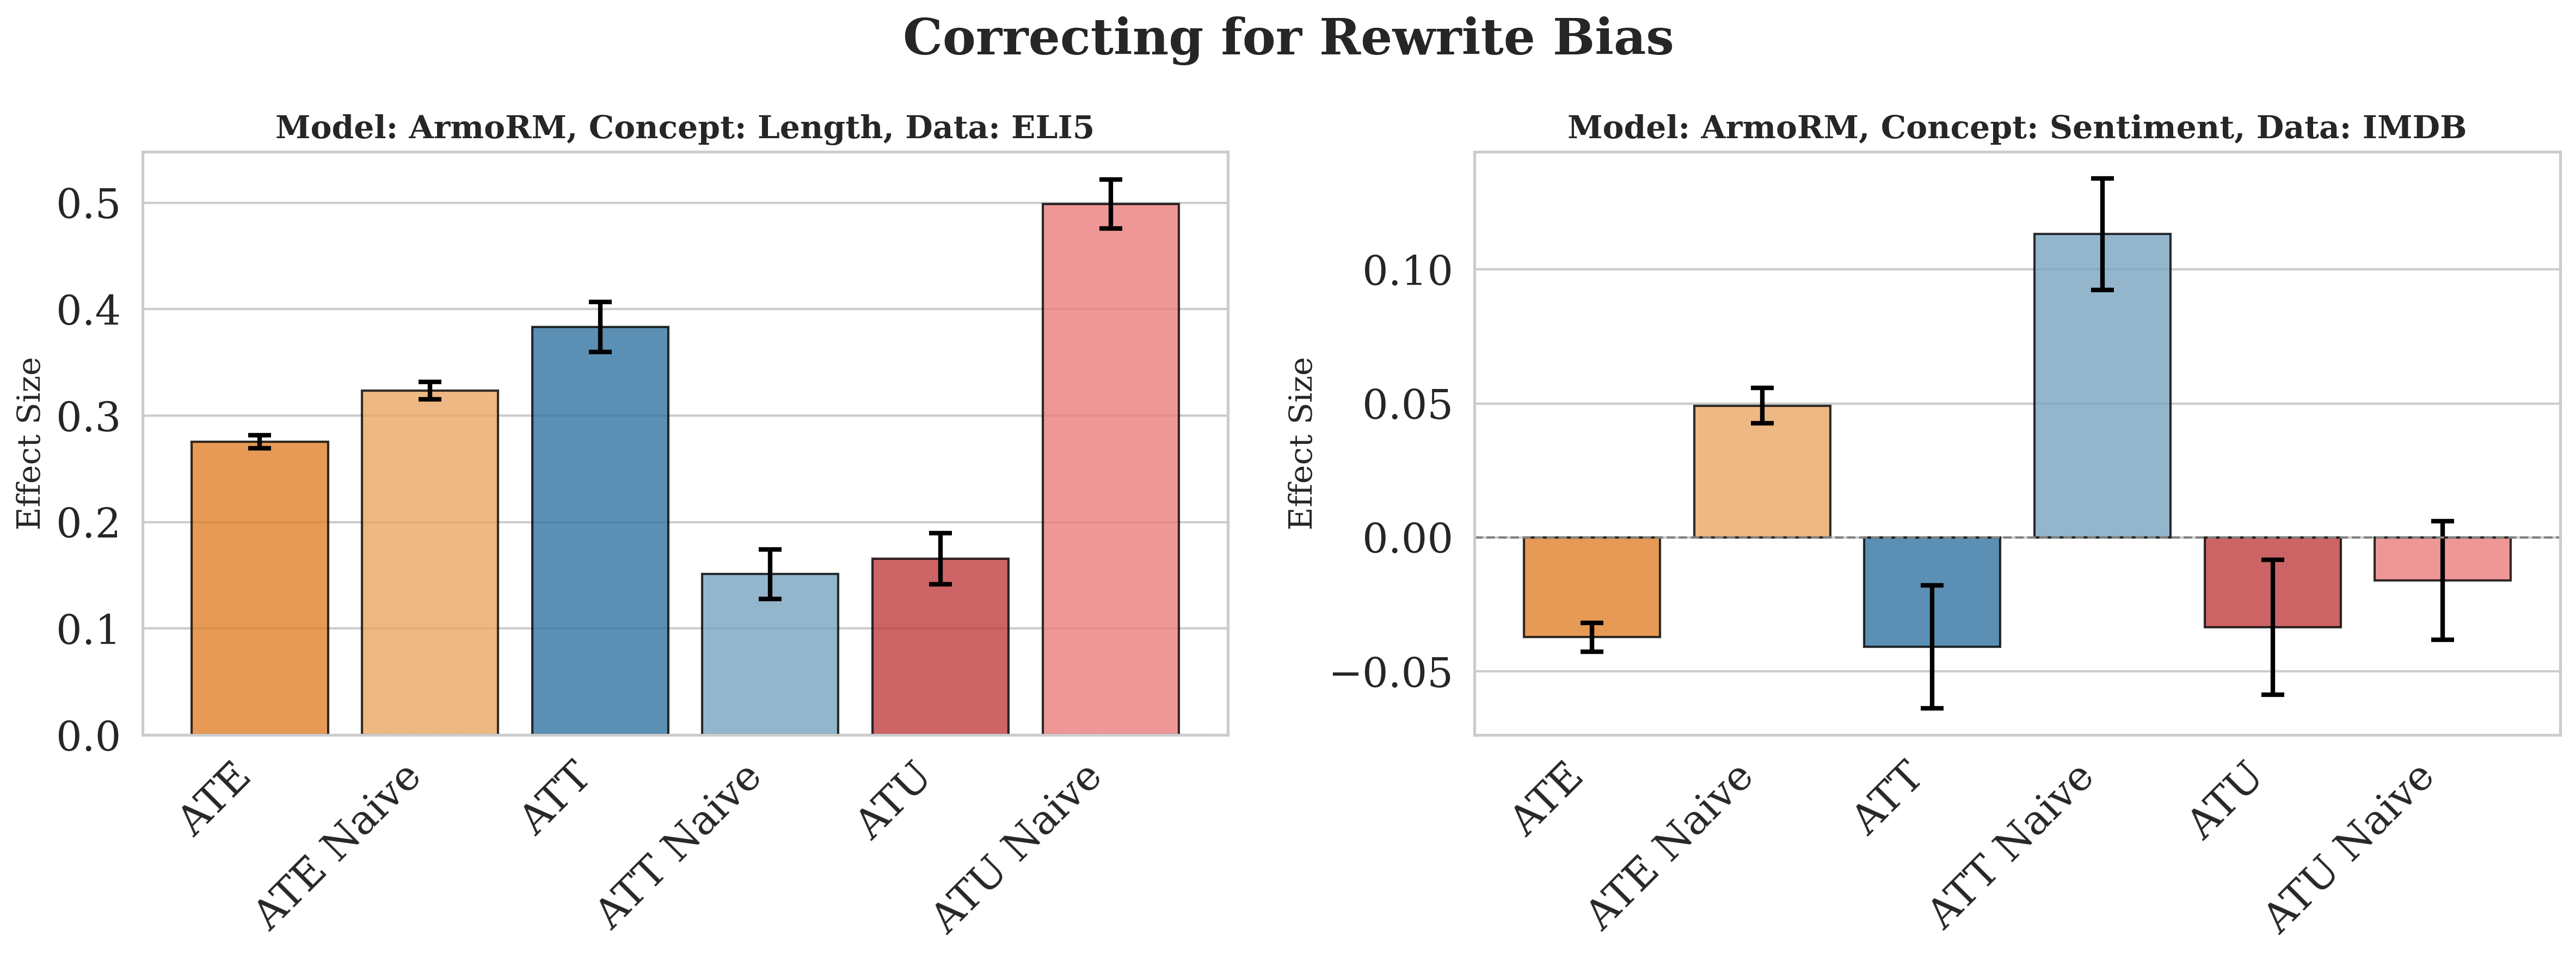

2024-10-02 00:08:30,524 - INFO - Number of w=1 examples: 12500
2024-10-02 00:08:30,524 - INFO - Number of w=0 examples: 12500
2024-10-02 00:08:30,579 - INFO - Treatment effects: {   'ATE': 0.7334859989929203,
    'ATE_naive': 0.5925840222167968,
    'ATE_stderr': 0.005159791439812839,
    'ATE_stderr_naive': 0.0050793778899746395,
    'ATT': 1.0226859603881833,
    'ATT_naive': 0.829148413085937,
    'ATT_stderr': 0.017562619743403958,
    'ATT_stderr_naive': 0.0170190932711199,
    'ATU': 0.4442860375976565,
    'ATU_naive': 0.3560196313476567,
    'ATU_stderr': 0.014392537519939748,
    'ATU_stderr_naive': 0.014422290086535467,
    'naive_effect': 0.8977546762084962,
    'naive_effect_naive': 0.6159507226562502,
    'naive_effect_stderr': 0.016593421698845392,
    'naive_effect_stderr_naive': 0.01604378017403302}
2024-10-02 00:08:30,580 - INFO - Calculated ATE (from ATT and ATU): 0.7334859989929199
2024-10-02 00:08:30,595 - INFO - Rewrite effects: {   'rewrite_effect_w_0': -0.0882664

Calculating treatment effects for IMDB dataset with sfairXC/FsfairX-LLaMA3-RM-v0.1 reward model...
Calculating treatment effects for IMDB dataset with NCSOFT/Llama-3-OffsetBias-RM-8B reward model...
Calculating treatment effects for IMDB dataset with ArmoRM reward model...


2024-10-02 00:08:30,753 - INFO - Treatment effects: {   'ATE': 0.011343356436509647,
    'ATE_naive': 0.009292077208869168,
    'ATE_stderr': 6.931196137964942e-05,
    'ATE_stderr_naive': 7.423837198465809e-05,
    'ATT': 0.01513852502033114,
    'ATT_naive': 0.013283757503032678,
    'ATT_stderr': 0.00020521678139051266,
    'ATT_stderr_naive': 0.0002020157066137194,
    'ATU': 0.00754818785268814,
    'ATU_naive': 0.0053003969147056434,
    'ATU_stderr': 0.00018371251998774453,
    'ATU_stderr_naive': 0.00018482368496936053,
    'naive_effect': 0.015152591927088802,
    'naive_effect_naive': 0.011050033471807844,
    'naive_effect_stderr': 0.00019595405735961784,
    'naive_effect_stderr_naive': 0.0001936592767606584}
2024-10-02 00:08:30,754 - INFO - Calculated ATE (from ATT and ATU): 0.01134335643650964
2024-10-02 00:08:30,769 - INFO - Rewrite effects: {   'rewrite_effect_w_0': -0.0022477909379824998,
    'rewrite_effect_w_0_stderr': 9.352802024737844e-05,
    'rewrite_effect_w_1':

{'ATE': 0.7334859989929203, 'ATE_stderr': 0.005159791439812839, 'ATT': 1.0226859603881833, 'ATT_stderr': 0.017562619743403958, 'ATU': 0.4442860375976565, 'ATU_stderr': 0.014392537519939748, 'naive_effect': 0.8977546762084962, 'naive_effect_stderr': 0.016593421698845392, 'ATE_naive': 0.5925840222167968, 'ATE_stderr_naive': 0.0050793778899746395, 'ATT_naive': 0.829148413085937, 'ATT_stderr_naive': 0.0170190932711199, 'ATU_naive': 0.3560196313476567, 'ATU_stderr_naive': 0.014422290086535467, 'naive_effect_naive': 0.6159507226562502, 'naive_effect_stderr_naive': 0.01604378017403302, 'rewrite_effect_w_1': 0.1935375473022461, 'rewrite_effect_w_1_stderr': 0.006072725008146053, 'rewrite_effect_w_0': -0.08826640625, 'rewrite_effect_w_0_stderr': 0.006623925292253624, 'reward_std': 1.3583146674840445, 'Y1_count': 12500, 'Y0_count': 12500, 'ATT_corrected': 0.9344195541381832, 'ATT_corrected_stderr': 0.02418654503565758, 'ATU_corrected': 0.2507484902954104, 'ATU_corrected_stderr': 0.020465262528085

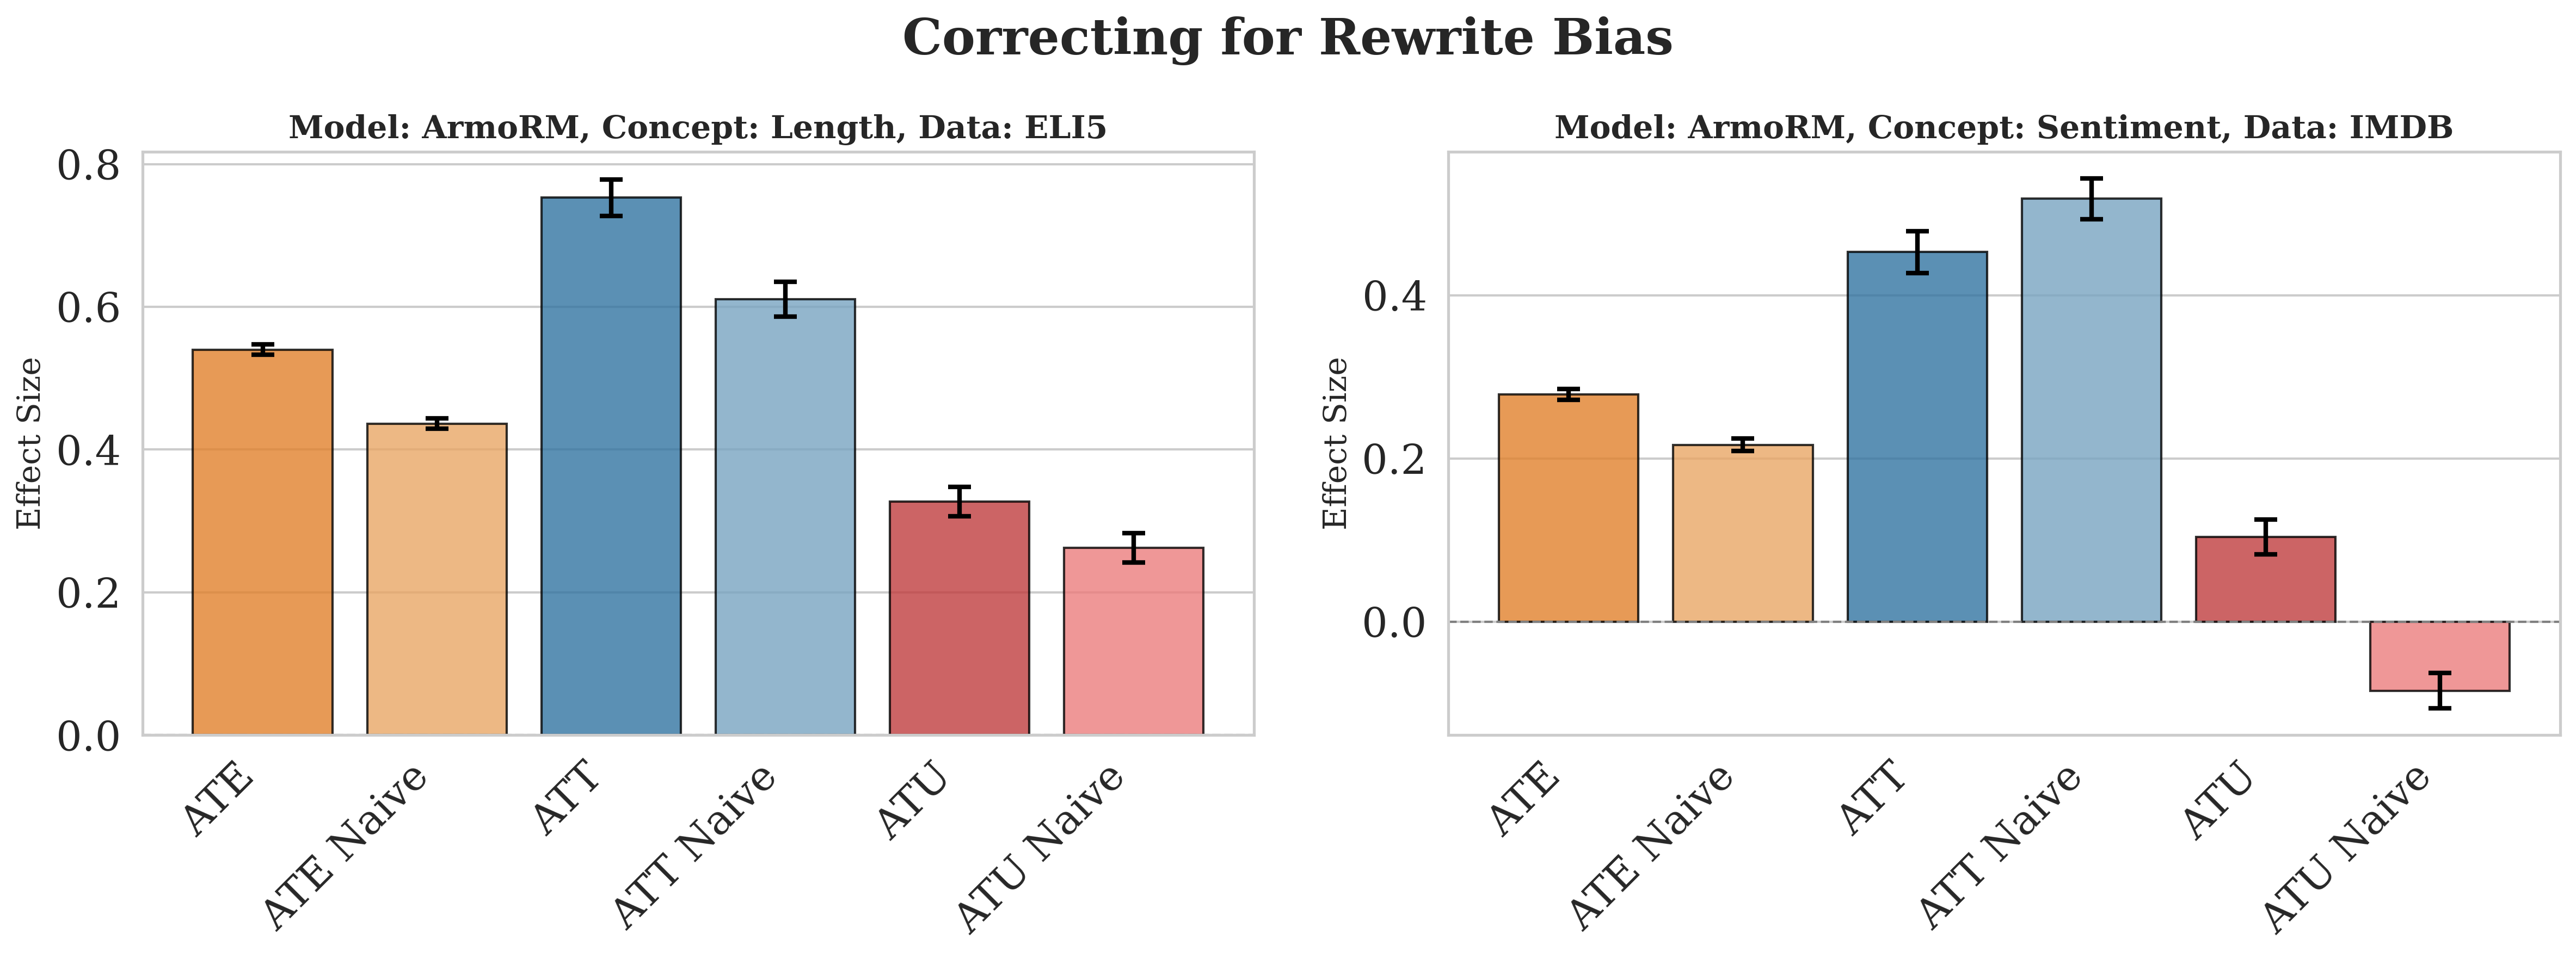

2024-10-02 00:08:32,253 - INFO - Number of w=1 examples: 12641
2024-10-02 00:08:32,254 - INFO - Number of w=0 examples: 12359
2024-10-02 00:08:32,313 - INFO - Treatment effects: {   'ATE': 0.3497249456787106,
    'ATE_naive': 0.8757635748291017,
    'ATE_stderr': 0.005192843009342133,
    'ATE_stderr_naive': 0.00802171890356659,
    'ATT': 0.4736422066559909,
    'ATT_naive': -0.1275277805803654,
    'ATT_stderr': 0.017001461859110324,
    'ATT_stderr_naive': 0.016033818522675217,
    'ATU': 0.22298021746333863,
    'ATU_naive': 1.9019474103927463,
    'ATU_stderr': 0.017386352799172847,
    'ATU_stderr_naive': 0.015401158797629093,
    'naive_effect': 0.23520599093757077,
    'naive_effect_naive': 1.3130031966306221,
    'naive_effect_stderr': 0.017313738022492194,
    'naive_effect_stderr_naive': 0.014237611598694293}
2024-10-02 00:08:32,314 - INFO - Calculated ATE (from ATT and ATU): 0.3497249456787113
2024-10-02 00:08:32,329 - INFO - Rewrite effects: {   'rewrite_effect_w_0': 1.678

Calculating treatment effects for IMDB dataset with sfairXC/FsfairX-LLaMA3-RM-v0.1 reward model...
Calculating treatment effects for IMDB dataset with NCSOFT/Llama-3-OffsetBias-RM-8B reward model...
Calculating treatment effects for IMDB dataset with ArmoRM reward model...


2024-10-02 00:08:32,489 - INFO - Treatment effects: {   'ATE': 0.00022227626480161855,
    'ATE_naive': 0.0035283253015950394,
    'ATE_stderr': 5.119318840976761e-05,
    'ATE_stderr_naive': 7.615770387584053e-05,
    'ATT': 0.002809935697109703,
    'ATT_naive': -0.004363937449299887,
    'ATT_stderr': 0.00022204853503122622,
    'ATT_stderr_naive': 0.00020862578108038027,
    'ATU': -0.0024244267762054544,
    'ATU_naive': 0.011600668811107356,
    'ATU_stderr': 0.0002244134118873855,
    'ATU_stderr_naive': 0.0002123528812427841,
    'naive_effect': 0.0007692351006602094,
    'naive_effect_naive': 0.00762045754156343,
    'naive_effect_stderr': 0.00022610320400971482,
    'naive_effect_stderr_naive': 0.00020018538963300598}
2024-10-02 00:08:32,490 - INFO - Calculated ATE (from ATT and ATU): 0.00022227626480162172
2024-10-02 00:08:32,505 - INFO - Rewrite effects: {   'rewrite_effect_w_0': 0.014025095587312809,
    'rewrite_effect_w_0_stderr': 9.675954930564845e-05,
    'rewrite_effe

{'ATE': 0.3497249456787106, 'ATE_stderr': 0.005192843009342133, 'ATT': 0.4736422066559909, 'ATT_stderr': 0.017001461859110324, 'ATU': 0.22298021746333863, 'ATU_stderr': 0.017386352799172847, 'naive_effect': 0.23520599093757077, 'naive_effect_stderr': 0.017313738022492194, 'ATE_naive': 0.8757635748291017, 'ATE_stderr_naive': 0.00802171890356659, 'ATT_naive': -0.1275277805803654, 'ATT_stderr_naive': 0.016033818522675217, 'ATU_naive': 1.9019474103927463, 'ATU_stderr_naive': 0.015401158797629093, 'naive_effect_naive': 1.3130031966306221, 'naive_effect_stderr_naive': 0.014237611598694293, 'rewrite_effect_w_1': 0.6011699872363567, 'rewrite_effect_w_1_stderr': 0.00932422167450009, 'rewrite_effect_w_0': 1.6789671929294079, 'rewrite_effect_w_0_stderr': 0.008981069268433374, 'reward_std': 1.388648756922758, 'Y1_count': 12641, 'Y0_count': 12359, 'ATT_corrected': 2.1526093995853985, 'ATT_corrected_stderr': 0.025982531127543698, 'ATU_corrected': -0.3781897697730181, 'ATU_corrected_stderr': 0.026710

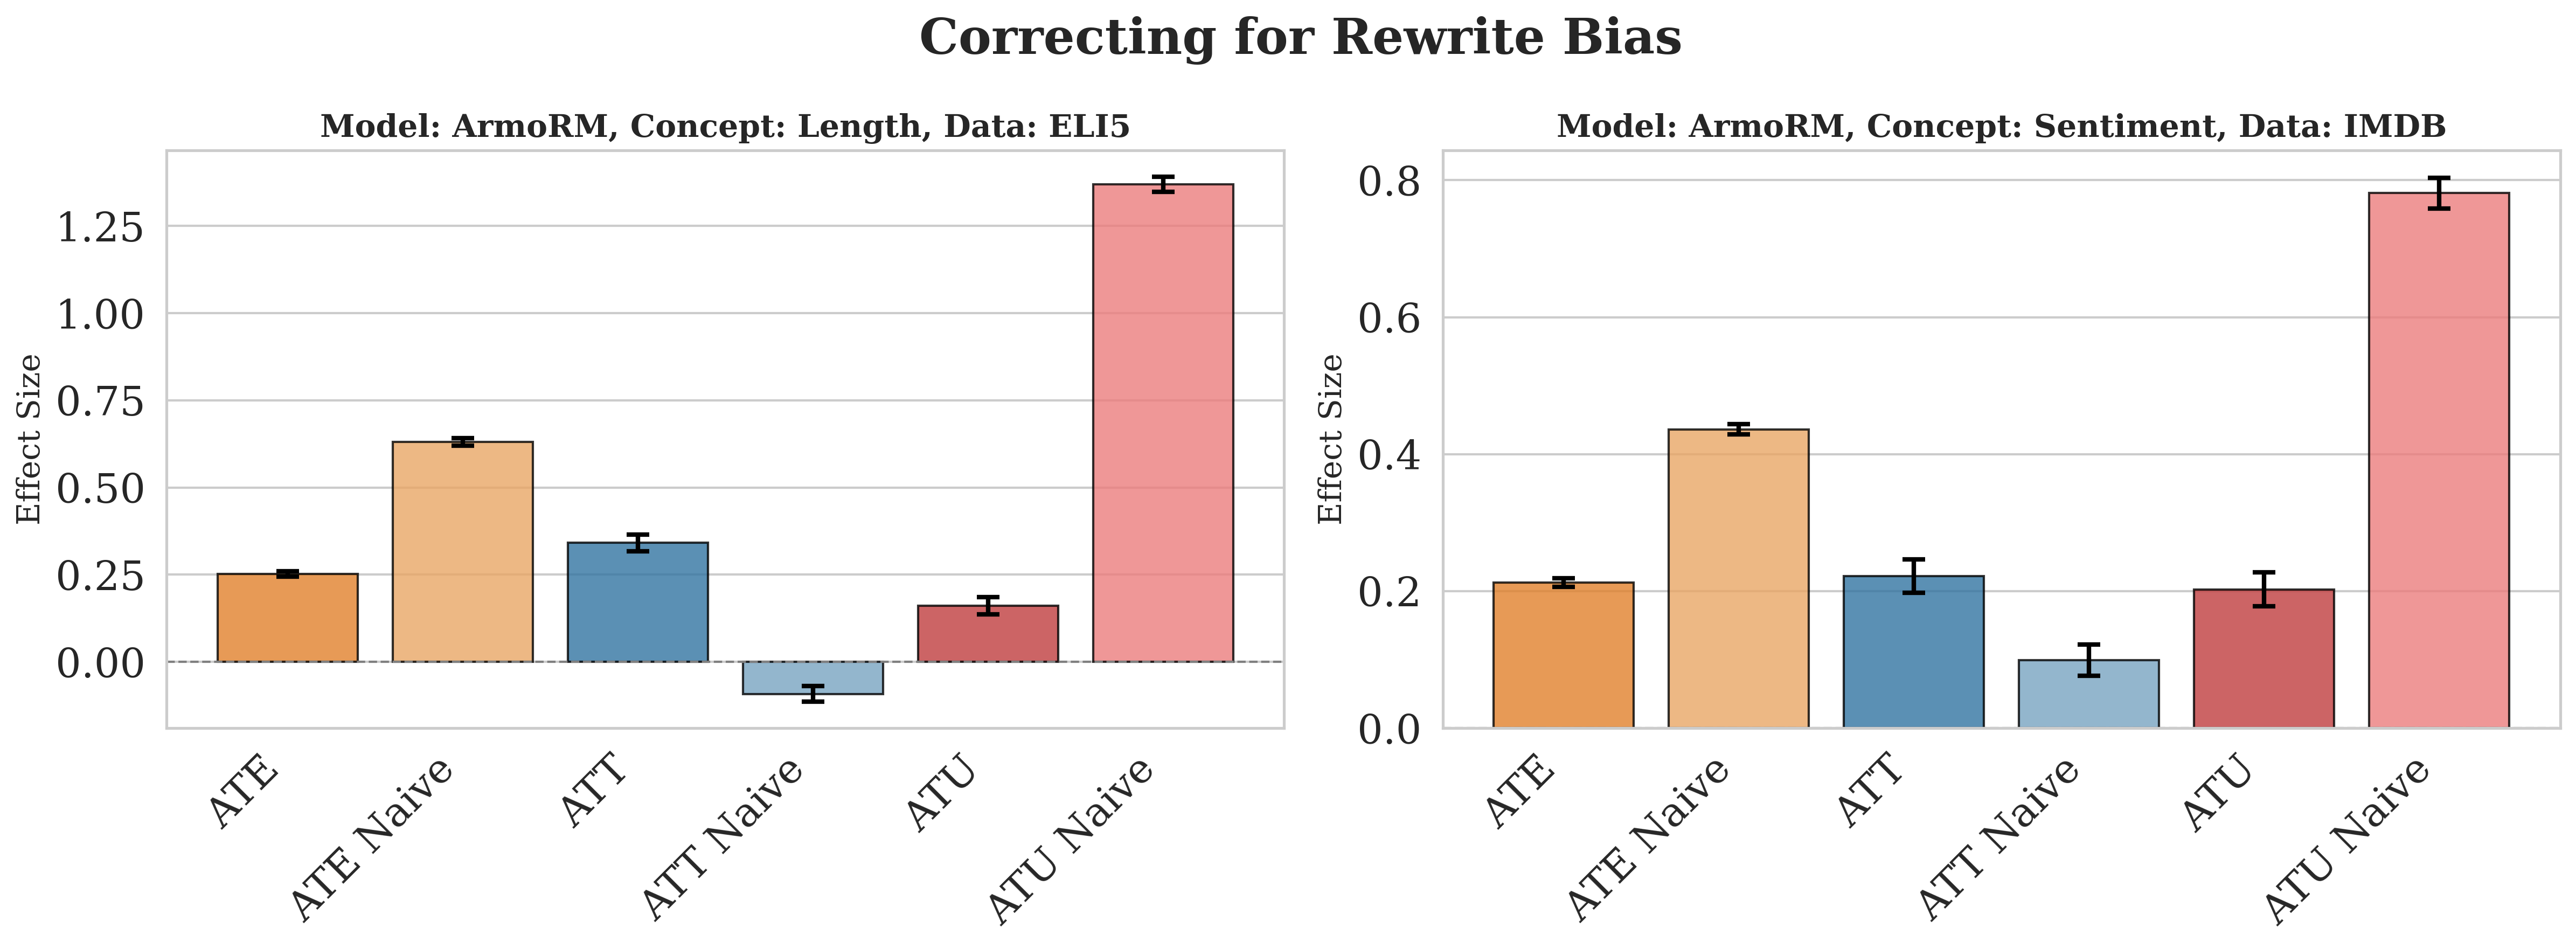

2024-10-02 00:08:34,295 - INFO - Number of w=1 examples: 2053
2024-10-02 00:08:34,296 - INFO - Number of w=0 examples: 22948
2024-10-02 00:08:34,354 - INFO - Treatment effects: {   'ATE': 0.9048051312562824,
    'ATE_naive': 0.7283239618863426,
    'ATE_stderr': 0.007146826503068671,
    'ATE_stderr_naive': 0.013520733556364913,
    'ATT': 1.4303391759011204,
    'ATT_naive': 0.583223911941313,
    'ATT_stderr': 0.08530180179699028,
    'ATT_stderr_naive': 0.07530472553707064,
    'ATU': 0.8577892085764911,
    'ATU_naive': 0.7413050671041024,
    'ATU_stderr': 0.0313506109987603,
    'ATU_stderr_naive': 0.02992447537986516,
    'naive_effect': 2.3245751307720224,
    'naive_effect_naive': 1.3609757253398262,
    'naive_effect_stderr': 0.06893023408749398,
    'naive_effect_stderr_naive': 0.05530275659062402}
2024-10-02 00:08:34,354 - INFO - Calculated ATE (from ATT and ATU): 0.9048051312562825
2024-10-02 00:08:34,371 - INFO - Rewrite effects: {   'rewrite_effect_w_0': -0.1164841414723

Calculating treatment effects for HelpSteer dataset with sfairXC/FsfairX-LLaMA3-RM-v0.1 reward model...
Calculating treatment effects for HelpSteer dataset with NCSOFT/Llama-3-OffsetBias-RM-8B reward model...
Calculating treatment effects for HelpSteer dataset with RLHFlow/ArmoRM-Llama3-8B-v0.1 reward model...


2024-10-02 00:08:34,530 - INFO - Treatment effects: {   'ATE': 0.005703649022972476,
    'ATE_naive': 0.0004790476761678958,
    'ATE_stderr': 9.084771586754362e-05,
    'ATE_stderr_naive': 0.000179627470859577,
    'ATT': 0.00919048489637117,
    'ATT_naive': 0.0049928189666975376,
    'ATT_stderr': 0.0011204232733925373,
    'ATT_stderr_naive': 0.0010069670323385245,
    'ATU': 0.0053917057578475175,
    'ATU_naive': 7.523155016748995e-05,
    'ATU_stderr': 0.00043555212537282266,
    'ATU_stderr_naive': 0.000406027729420563,
    'naive_effect': 0.02173168549944894,
    'naive_effect_naive': 0.01221754536209528,
    'naive_effect_stderr': 0.0009021080197085503,
    'naive_effect_stderr_naive': 0.0007399905641433033}
2024-10-02 00:08:34,531 - INFO - Calculated ATE (from ATT and ATU): 0.005703649022972475
2024-10-02 00:08:34,547 - INFO - Rewrite effects: {   'rewrite_effect_w_0': -0.005316474207680032,
    'rewrite_effect_w_0_stderr': 0.00017326767418500183,
    'rewrite_effect_w_1': 0

{'ATE': 0.9048051312562824, 'ATE_stderr': 0.007146826503068671, 'ATT': 1.4303391759011204, 'ATT_stderr': 0.08530180179699028, 'ATU': 0.8577892085764911, 'ATU_stderr': 0.0313506109987603, 'naive_effect': 2.3245751307720224, 'naive_effect_stderr': 0.06893023408749398, 'ATE_naive': 0.7283239618863426, 'ATE_stderr_naive': 0.013520733556364913, 'ATT_naive': 0.583223911941313, 'ATT_stderr_naive': 0.07530472553707064, 'ATU_naive': 0.7413050671041024, 'ATU_stderr_naive': 0.02992447537986516, 'naive_effect_naive': 1.3609757253398262, 'naive_effect_stderr_naive': 0.05530275659062402, 'rewrite_effect_w_1': 0.8471152639598075, 'rewrite_effect_w_1_stderr': 0.039467361901497626, 'rewrite_effect_w_0': -0.11648414147238875, 'rewrite_effect_w_0_stderr': 0.012574202353372331, 'reward_std': 3.5037755624444995, 'Y1_count': 2053, 'Y0_count': 22948, 'ATT_corrected': 1.3138550344287316, 'ATT_corrected_stderr': 0.09787600415036261, 'ATU_corrected': 0.010673944616683584, 'ATU_corrected_stderr': 0.0708179729002

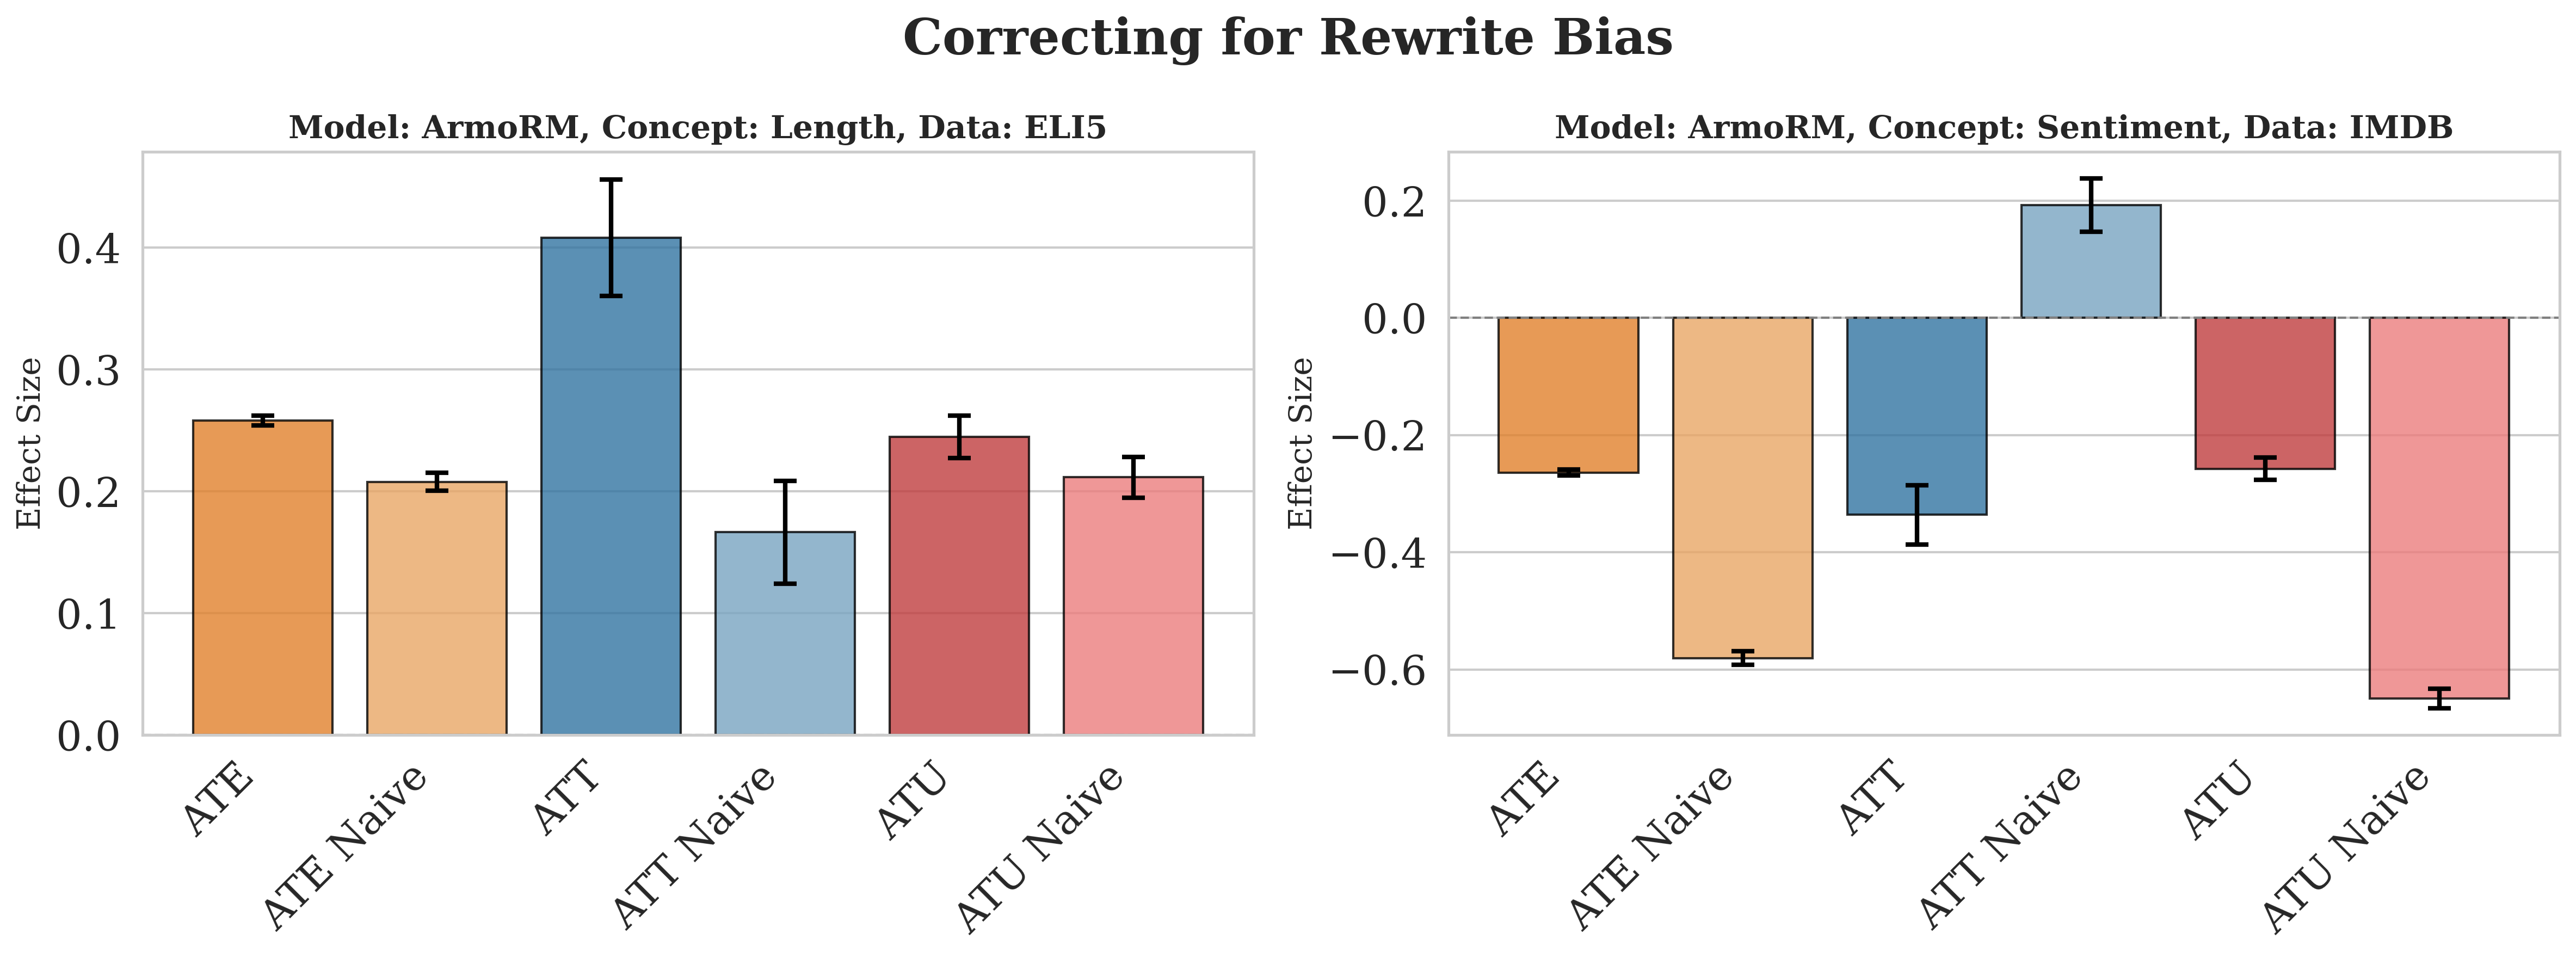

2024-10-02 00:08:36,171 - INFO - Number of w=1 examples: 17343
2024-10-02 00:08:36,171 - INFO - Number of w=0 examples: 7658
2024-10-02 00:08:36,229 - INFO - Treatment effects: {   'ATE': 0.9571304520026844,
    'ATE_naive': 2.5413189436701713,
    'ATE_stderr': 0.011692205690379237,
    'ATE_stderr_naive': 0.018426032817953738,
    'ATT': 0.45381670834551713,
    'ATT_naive': 3.6944396392027343,
    'ATT_stderr': 0.029220597945883255,
    'ATT_stderr_naive': 0.02580912438919434,
    'ATU': 2.0969803157068165,
    'ATU_naive': -0.07014256359298532,
    'ATU_stderr': 0.04813963940433435,
    'ATU_stderr_naive': 0.050896619737238455,
    'naive_effect': 1.9775581047886774,
    'naive_effect_naive': 3.051058156346093,
    'naive_effect_stderr': 0.03668141507763341,
    'naive_effect_stderr_naive': 0.037826376884619706}
2024-10-02 00:08:36,230 - INFO - Calculated ATE (from ATT and ATU): 0.9571304520026841
2024-10-02 00:08:36,247 - INFO - Rewrite effects: {   'rewrite_effect_w_0': -2.167122

Calculating treatment effects for HelpSteer dataset with sfairXC/FsfairX-LLaMA3-RM-v0.1 reward model...
Calculating treatment effects for HelpSteer dataset with NCSOFT/Llama-3-OffsetBias-RM-8B reward model...
Calculating treatment effects for HelpSteer dataset with RLHFlow/ArmoRM-Llama3-8B-v0.1 reward model...


2024-10-02 00:08:36,427 - INFO - Treatment effects: {   'ATE': 0.010495950486209896,
    'ATE_naive': 0.027987056860465778,
    'ATE_stderr': 0.0001582658154475066,
    'ATE_stderr_naive': 0.00023710672570932583,
    'ATT': 0.005374643585684208,
    'ATT_naive': 0.04165628012091653,
    'ATT_stderr': 0.0004337538899742728,
    'ATT_stderr_naive': 0.0003826500972534713,
    'ATU': 0.02209412567239652,
    'ATU_naive': -0.002969503469385029,
    'ATU_stderr': 0.0006493664855271454,
    'ATU_stderr_naive': 0.0006720789538375102,
    'naive_effect': 0.024080891454620473,
    'naive_effect_naive': 0.03529889884807125,
    'naive_effect_stderr': 0.0005177850398684973,
    'naive_effect_stderr_naive': 0.0005063529352510408}
2024-10-02 00:08:36,428 - INFO - Calculated ATE (from ATT and ATU): 0.010495950486209903
2024-10-02 00:08:36,444 - INFO - Rewrite effects: {   'rewrite_effect_w_0': -0.025063629141781545,
    'rewrite_effect_w_0_stderr': 0.00036768213109976644,
    'rewrite_effect_w_1': -0

{'ATE': 0.9571304520026844, 'ATE_stderr': 0.011692205690379237, 'ATT': 0.45381670834551713, 'ATT_stderr': 0.029220597945883255, 'ATU': 2.0969803157068165, 'ATU_stderr': 0.04813963940433435, 'naive_effect': 1.9775581047886774, 'naive_effect_stderr': 0.03668141507763341, 'ATE_naive': 2.5413189436701713, 'ATE_stderr_naive': 0.018426032817953738, 'ATT_naive': 3.6944396392027343, 'ATT_stderr_naive': 0.02580912438919434, 'ATU_naive': -0.07014256359298532, 'ATU_stderr_naive': 0.050896619737238455, 'naive_effect_naive': 3.051058156346093, 'naive_effect_stderr_naive': 0.037826376884619706, 'rewrite_effect_w_1': -3.240622930857217, 'rewrite_effect_w_1_stderr': 0.018863484150456068, 'rewrite_effect_w_0': -2.1671228792998023, 'rewrite_effect_w_0_stderr': 0.02688823206073272, 'reward_std': 2.966819166225167, 'Y1_count': 17343, 'Y0_count': 7658, 'ATT_corrected': -1.7133061709542852, 'ATT_corrected_stderr': 0.05610883000661598, 'ATU_corrected': 5.337603246564034, 'ATU_corrected_stderr': 0.06700312355

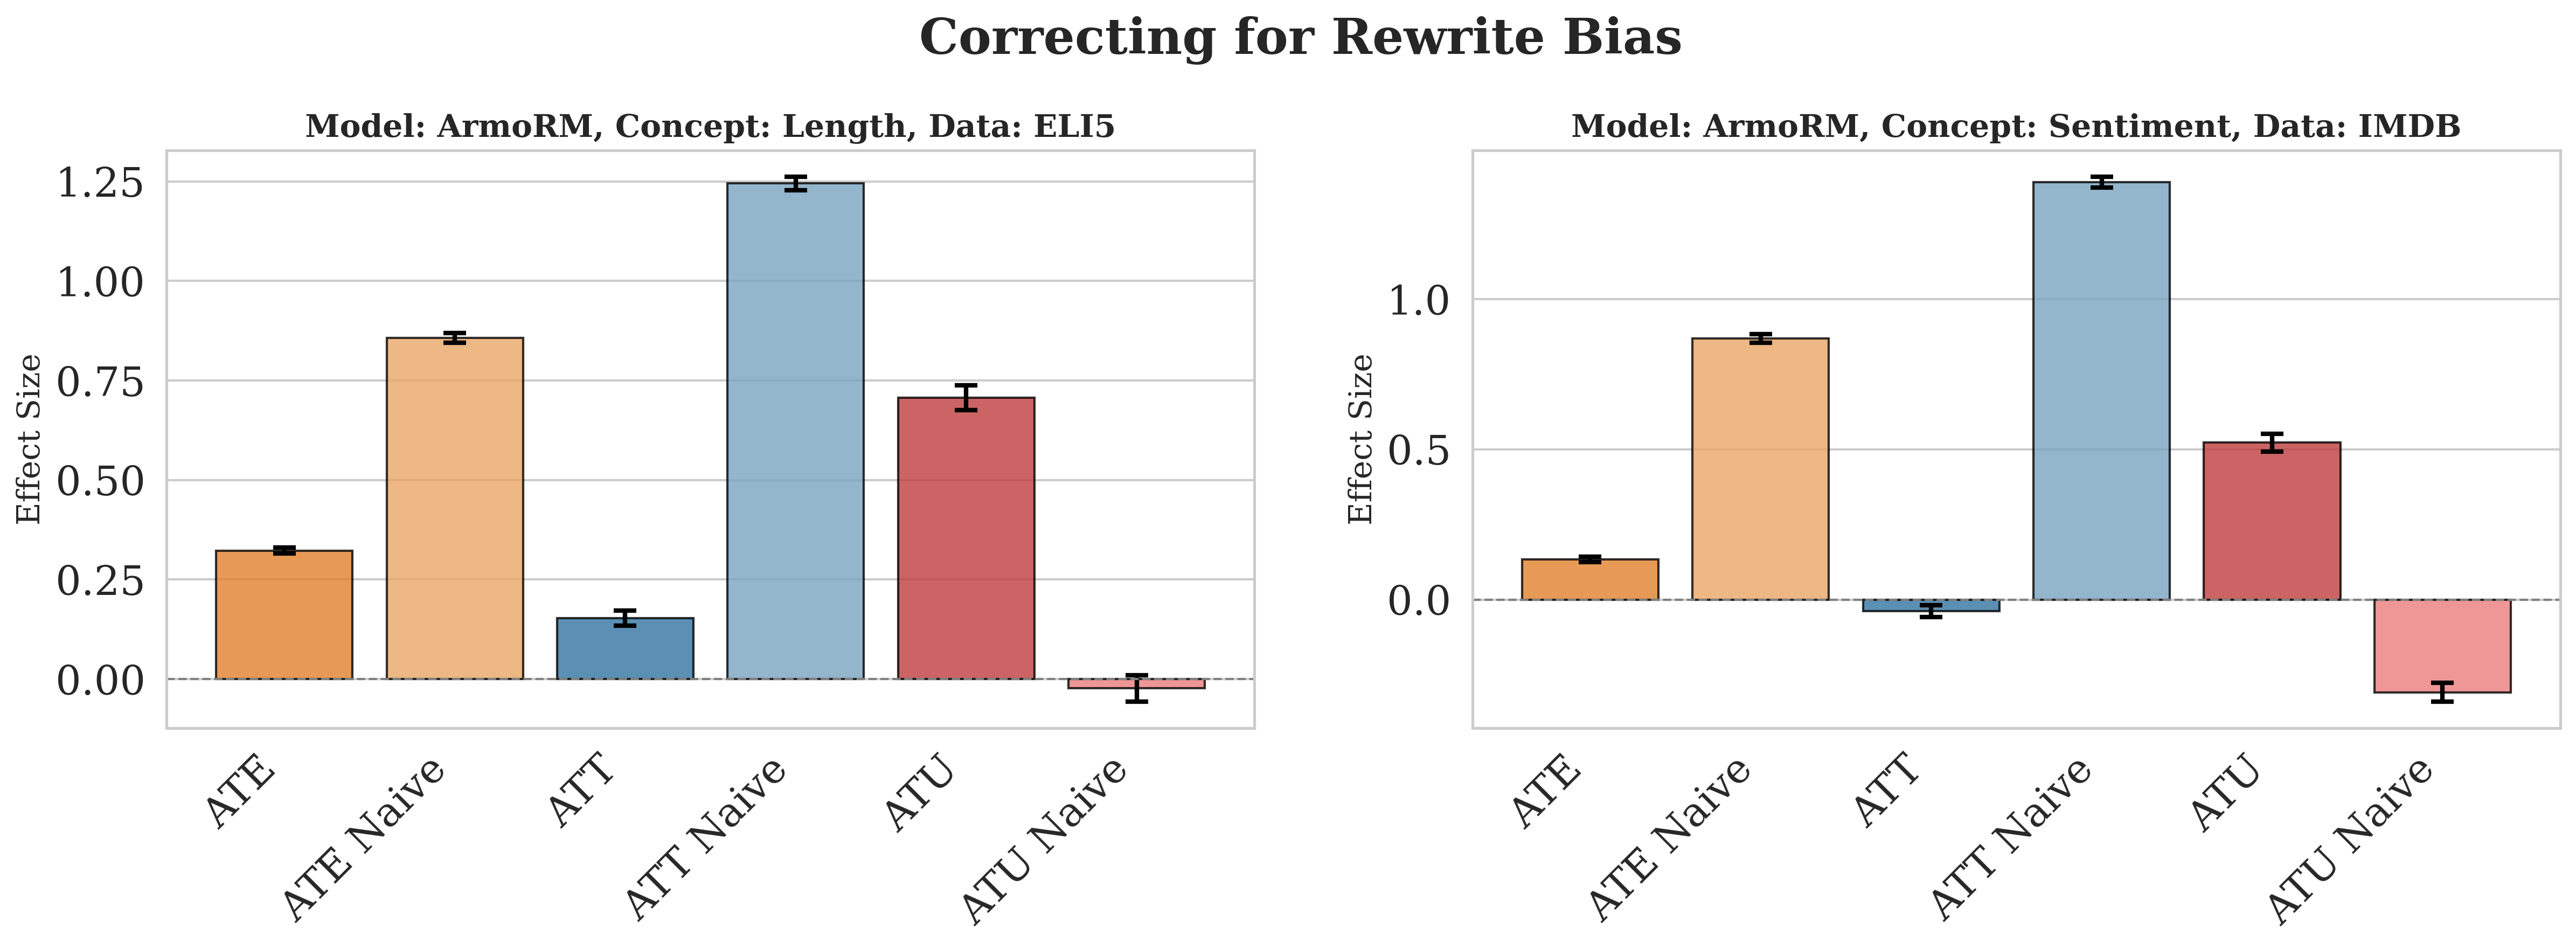

2024-10-02 00:08:37,755 - INFO - Number of w=1 examples: 10100
2024-10-02 00:08:37,755 - INFO - Number of w=0 examples: 14900
2024-10-02 00:08:37,812 - INFO - Treatment effects: {   'ATE': 0.9382989306640619,
    'ATE_naive': 0.45841240722656185,
    'ATE_stderr': 0.006938500147005801,
    'ATE_stderr_naive': 0.006979753558265907,
    'ATT': 0.9745804044515776,
    'ATT_naive': 1.1585991646039595,
    'ATT_stderr': 0.02376804266319825,
    'ATT_stderr_naive': 0.02170579666468689,
    'ATU': 0.9137054484322569,
    'ATU_naive': -0.016210830995700753,
    'ATU_stderr': 0.019114093329061034,
    'ATU_stderr_naive': 0.018695982453501462,
    'naive_effect': 1.2588552418220278,
    'naive_effect_naive': 0.5129577225464521,
    'naive_effect_stderr': 0.022228523437168336,
    'naive_effect_stderr_naive': 0.019609186804032473}
2024-10-02 00:08:37,813 - INFO - Calculated ATE (from ATT and ATU): 0.9382989306640624
2024-10-02 00:08:37,830 - INFO - Rewrite effects: {   'rewrite_effect_w_0': -0.92

Calculating treatment effects for HH-RLHF dataset with sfairXC/FsfairX-LLaMA3-RM-v0.1 reward model...
Calculating treatment effects for HH-RLHF dataset with NCSOFT/Llama-3-OffsetBias-RM-8B reward model...
Calculating treatment effects for HH-RLHF dataset with RLHFlow/ArmoRM-Llama3-8B-v0.1 reward model...


2024-10-02 00:08:38,005 - INFO - Treatment effects: {   'ATE': 0.014154800119800498,
    'ATE_naive': 0.0068042106896825105,
    'ATE_stderr': 9.897726946925373e-05,
    'ATE_stderr_naive': 9.752806849806856e-05,
    'ATT': 0.014678357080372031,
    'ATT_naive': 0.01682548800206715,
    'ATT_stderr': 0.00034287793573565276,
    'ATT_stderr_naive': 0.00032537344782222836,
    'ATU': 0.013799905804245283,
    'ATU_naive': 1.1264323569432078e-05,
    'ATU_stderr': 0.00028420030174002177,
    'ATU_stderr_naive': 0.0002774948710322625,
    'naive_effect': 0.018452276309963864,
    'naive_effect_naive': 0.006810765750983133,
    'naive_effect_stderr': 0.00031980096626904017,
    'naive_effect_stderr_naive': 0.00029463341918405366}
2024-10-02 00:08:38,006 - INFO - Calculated ATE (from ATT and ATU): 0.01415480011980049
2024-10-02 00:08:38,023 - INFO - Rewrite effects: {   'rewrite_effect_w_0': -0.013788641480675854,
    'rewrite_effect_w_0_stderr': 0.00012708701302345537,
    'rewrite_effect_w

{'ATE': 0.9382989306640619, 'ATE_stderr': 0.006938500147005801, 'ATT': 0.9745804044515776, 'ATT_stderr': 0.02376804266319825, 'ATU': 0.9137054484322569, 'ATU_stderr': 0.019114093329061034, 'naive_effect': 1.2588552418220278, 'naive_effect_stderr': 0.022228523437168336, 'ATE_naive': 0.45841240722656185, 'ATE_stderr_naive': 0.006979753558265907, 'ATT_naive': 1.1585991646039595, 'ATT_stderr_naive': 0.02170579666468689, 'ATU_naive': -0.016210830995700753, 'ATU_stderr_naive': 0.018695982453501462, 'naive_effect_naive': 0.5129577225464521, 'naive_effect_stderr_naive': 0.019609186804032473, 'rewrite_effect_w_1': -0.18401876015238242, 'rewrite_effect_w_1_stderr': 0.0092790726425629, 'rewrite_effect_w_0': -0.9299162794279572, 'rewrite_effect_w_0_stderr': 0.00907662157659223, 'reward_std': 1.735617975598823, 'Y1_count': 10100, 'Y0_count': 14900, 'ATT_corrected': 0.04466412502362038, 'ATT_corrected_stderr': 0.03284466423979048, 'ATU_corrected': 1.0977242085846393, 'ATU_corrected_stderr': 0.028393

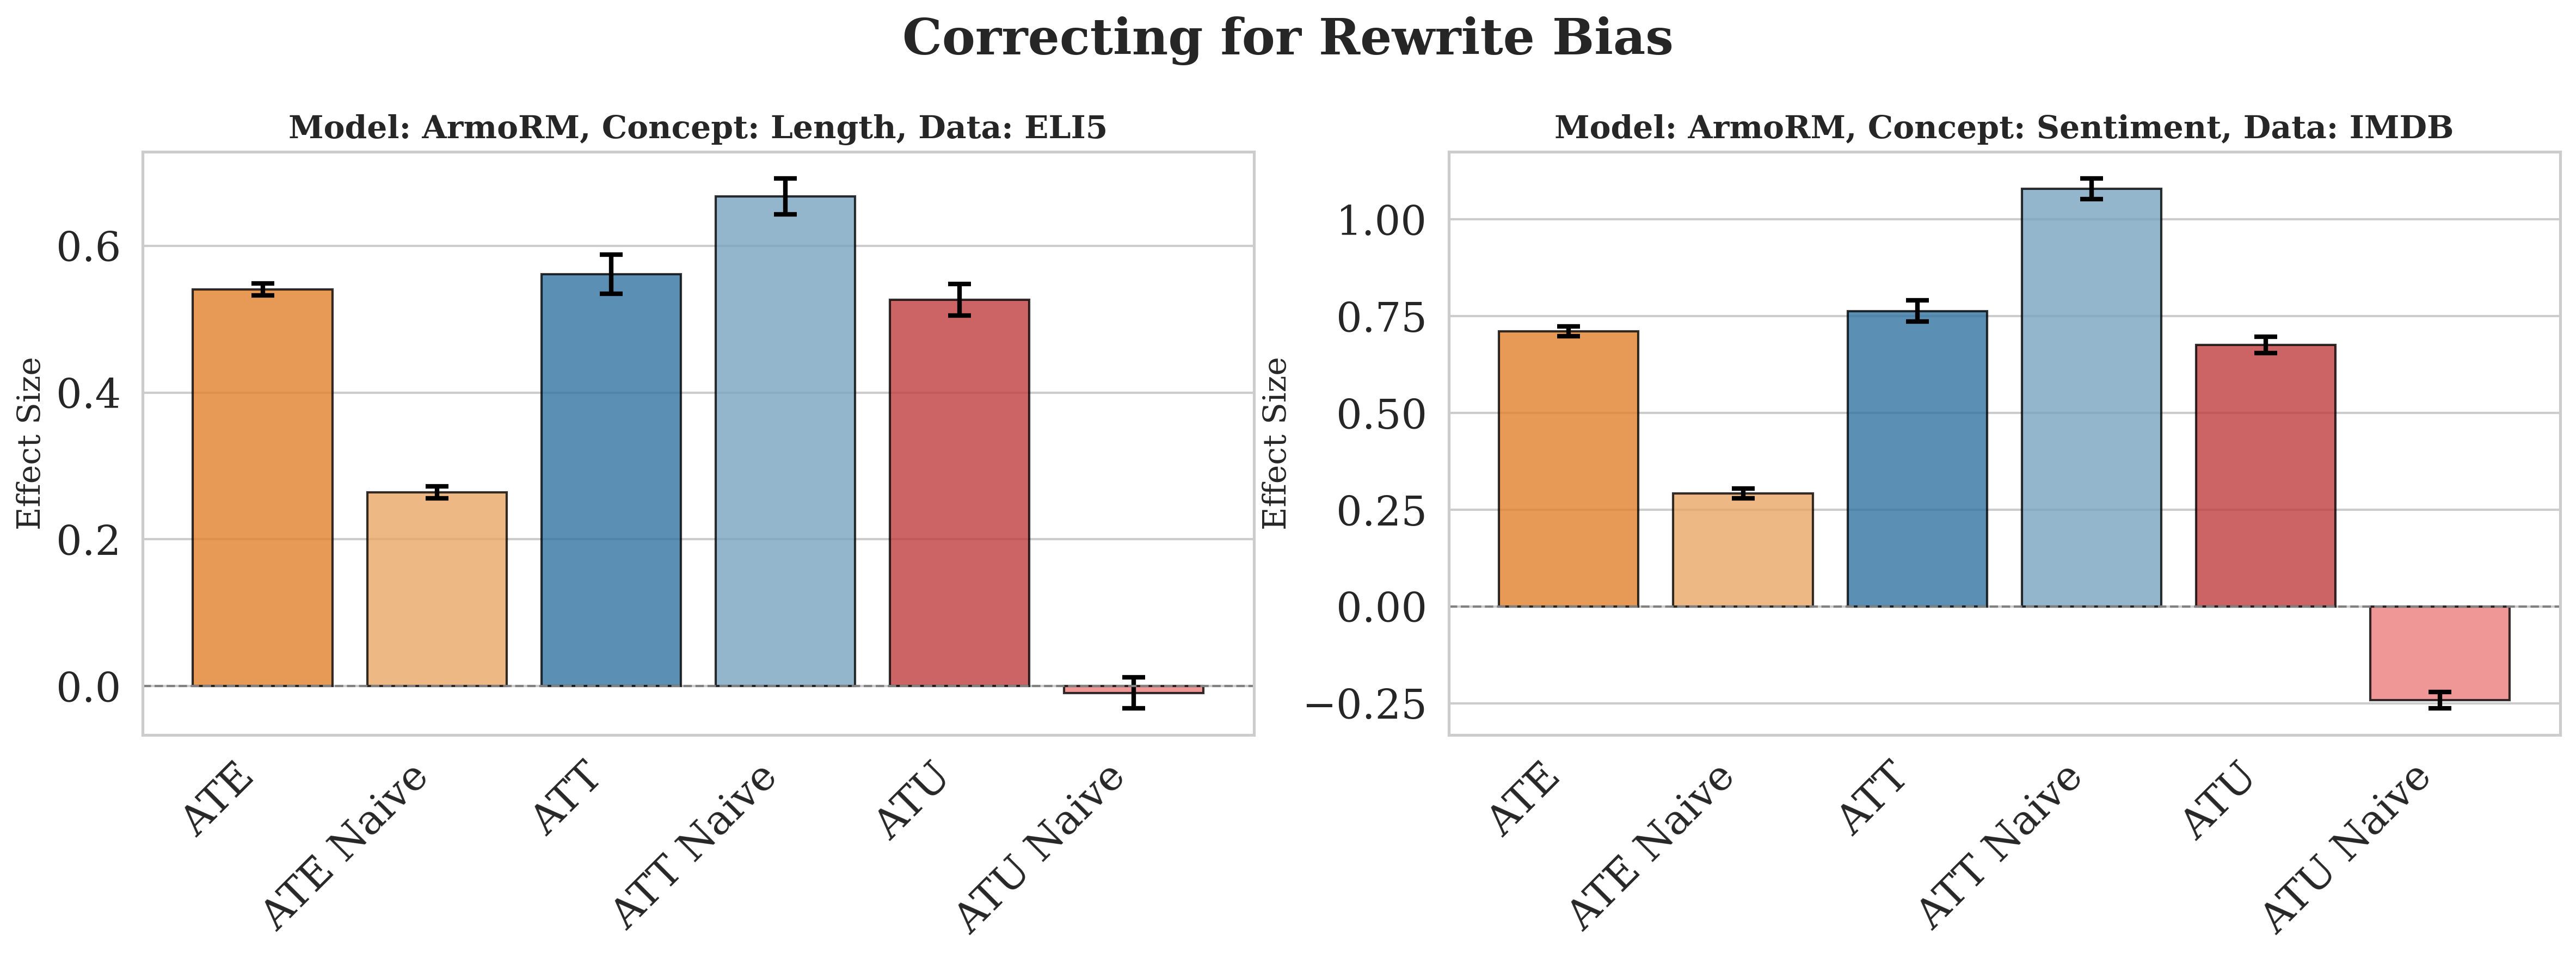

In [12]:
# more_templates =  [
#     # {
#     #     "dataset_name": "ELI5",
#     #     "concept": "Length",
#     #     "score": "ArmoRM",
#     #     "reward_key": "ArmoRM",
#     #     "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
#     # },     
#     # {
#     #     "dataset_name": "IMDB",
#     #     "concept": "Sentiment",
#     #     "score": "ArmoRM",
#     #     "reward_key": "ArmoRM",
#     #     "dataset_filename": "imdb_sentiment_complete_scored_20240919_152739.jsonl"
#     # },
#     # {
#     #     "dataset_name": "HelpSteer",
#     #     "concept": "Complexity",
#     #     "score": "ArmoRM",
#     #     "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
#     #     "dataset_filename": "helpsteer_complexity_complete_scored.jsonl"
#     # },
# #     {
# #         "dataset_name": "HelpSteer",
# #         "concept": "Helpfulness",
# #         "score": "ArmoRM",
# #         "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
# #         "dataset_filename": "helpsteer_helpfulness_complete_scored.jsonl"
# #     },
# #     # {
# #     #     "dataset_name": "IMDB",
# #     #     "concept": "Length",
# #     #     "score": "ArmoRM",
# #     #     "reward_key": "ArmoRM",
# #     #     "dataset_filename": "imdb_length_complete_scored_20240921_172425.jsonl"
# #     # },
# #     {
# #         "dataset_name": "HH-RLHF",
# #         "concept": "Sentiment",
# #         "score": "ArmoRM",
# #         "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
# #         "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
# #     }
# # ]

more_templates =  [
    {
        "dataset_name": "ELI5",
        "concept": "Length",
        # "score": "ArmoRM",
        # "reward_key": "ArmoRM",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    },     
    {
        "dataset_name": "IMDB",
        "concept": "Sentiment",
        # "score": "ArmoRM",
        # "reward_key": "ArmoRM",
        "dataset_filename": "imdb_sentiment_complete_scored_20240919_152739.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        # "score": "ArmoRM",
        # "reward_key": "ArmoRM",
        "dataset_filename": "imdb_length_complete_scored_20240921_172425.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Complexity",
        # "score": "ArmoRM",
        # "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "helpsteer_complexity_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        # "score": "ArmoRM",
        # "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "helpsteer_helpfulness_complete_scored.jsonl"
    },
    {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        # "score": "ArmoRM",
        # "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    }
]

reward_models = [
    "sfairXC/FsfairX-LLaMA3-RM-v0.1",
    "NCSOFT/Llama-3-OffsetBias-RM-8B",
    "RLHFlow/ArmoRM-Llama3-8B-v0.1",
]

for effects_template in more_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "complete" / dataset_filename)
    
    effects_by_model = []
    for reward_model in reward_models:
        effects_template["reward_key"] = reward_model
        if reward_model == "RLHFlow/ArmoRM-Llama3-8B-v0.1":
            if effects_template["dataset_name"] == "ELI5" or effects_template["dataset_name"] == "IMDB":
                effects_template["reward_key"] = "ArmoRM"
        print(f"Calculating treatment effects for {effects_template['dataset_name']} dataset with {effects_template['reward_key']} reward model...")
        effects = calculate_treatment_effects(dataset, **effects_template)
        effects['reward_model'] = reward_model
        effects['concept'] = effects_template['concept']
        effects['dataset'] = effects_template['dataset_name']
        effects_by_model.append(effects)
    rewrite_bias(effects_by_model)

In [13]:
synthetic_templates = [
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_0.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_1.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_2.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_3.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_4.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_5.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_6.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_7.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_8.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_9.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_10.jsonl"
    }
]
synthetic_neg_templates = [
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_0.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_1.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_2.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_3.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_4.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_5.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_6.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_7.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_8.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_9.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_negative_10.jsonl"
    }
]

In [14]:
# save all the data
synthetic_data = []
for effects_template in synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic" / "positive_long" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    synthetic_data.append(effects)

2024-10-02 00:08:39,227 - INFO - Number of w=1 examples: 4004
2024-10-02 00:08:39,228 - INFO - Number of w=0 examples: 5372
2024-10-02 00:08:39,251 - INFO - Treatment effects: {   'ATE': 0.0844035465969567,
    'ATE_naive': 0.16884899790376523,
    'ATE_stderr': 0.008534547037940212,
    'ATE_stderr_naive': 0.01354892736882799,
    'ATT': 0.2384955123230651,
    'ATT_naive': -0.330754465871043,
    'ATT_stderr': 0.06947906261246611,
    'ATT_stderr_naive': 0.0658152432122367,
    'ATU': -0.0304483206344911,
    'ATU_naive': 0.5412265610002531,
    'ATU_stderr': 0.0685568950220651,
    'ATU_stderr_naive': 0.06504727320061249,
    'naive_effect': -0.25964819403447226,
    'naive_effect_naive': -0.2572232905938362,
    'naive_effect_stderr': 0.07015354089099915,
    'naive_effect_stderr_naive': 0.06290409599455854}
2024-10-02 00:08:39,252 - INFO - Calculated ATE (from ATT and ATU): 0.08440354659695674
2024-10-02 00:08:39,258 - INFO - Rewrite effects: {   'rewrite_effect_w_0': 0.5716748816

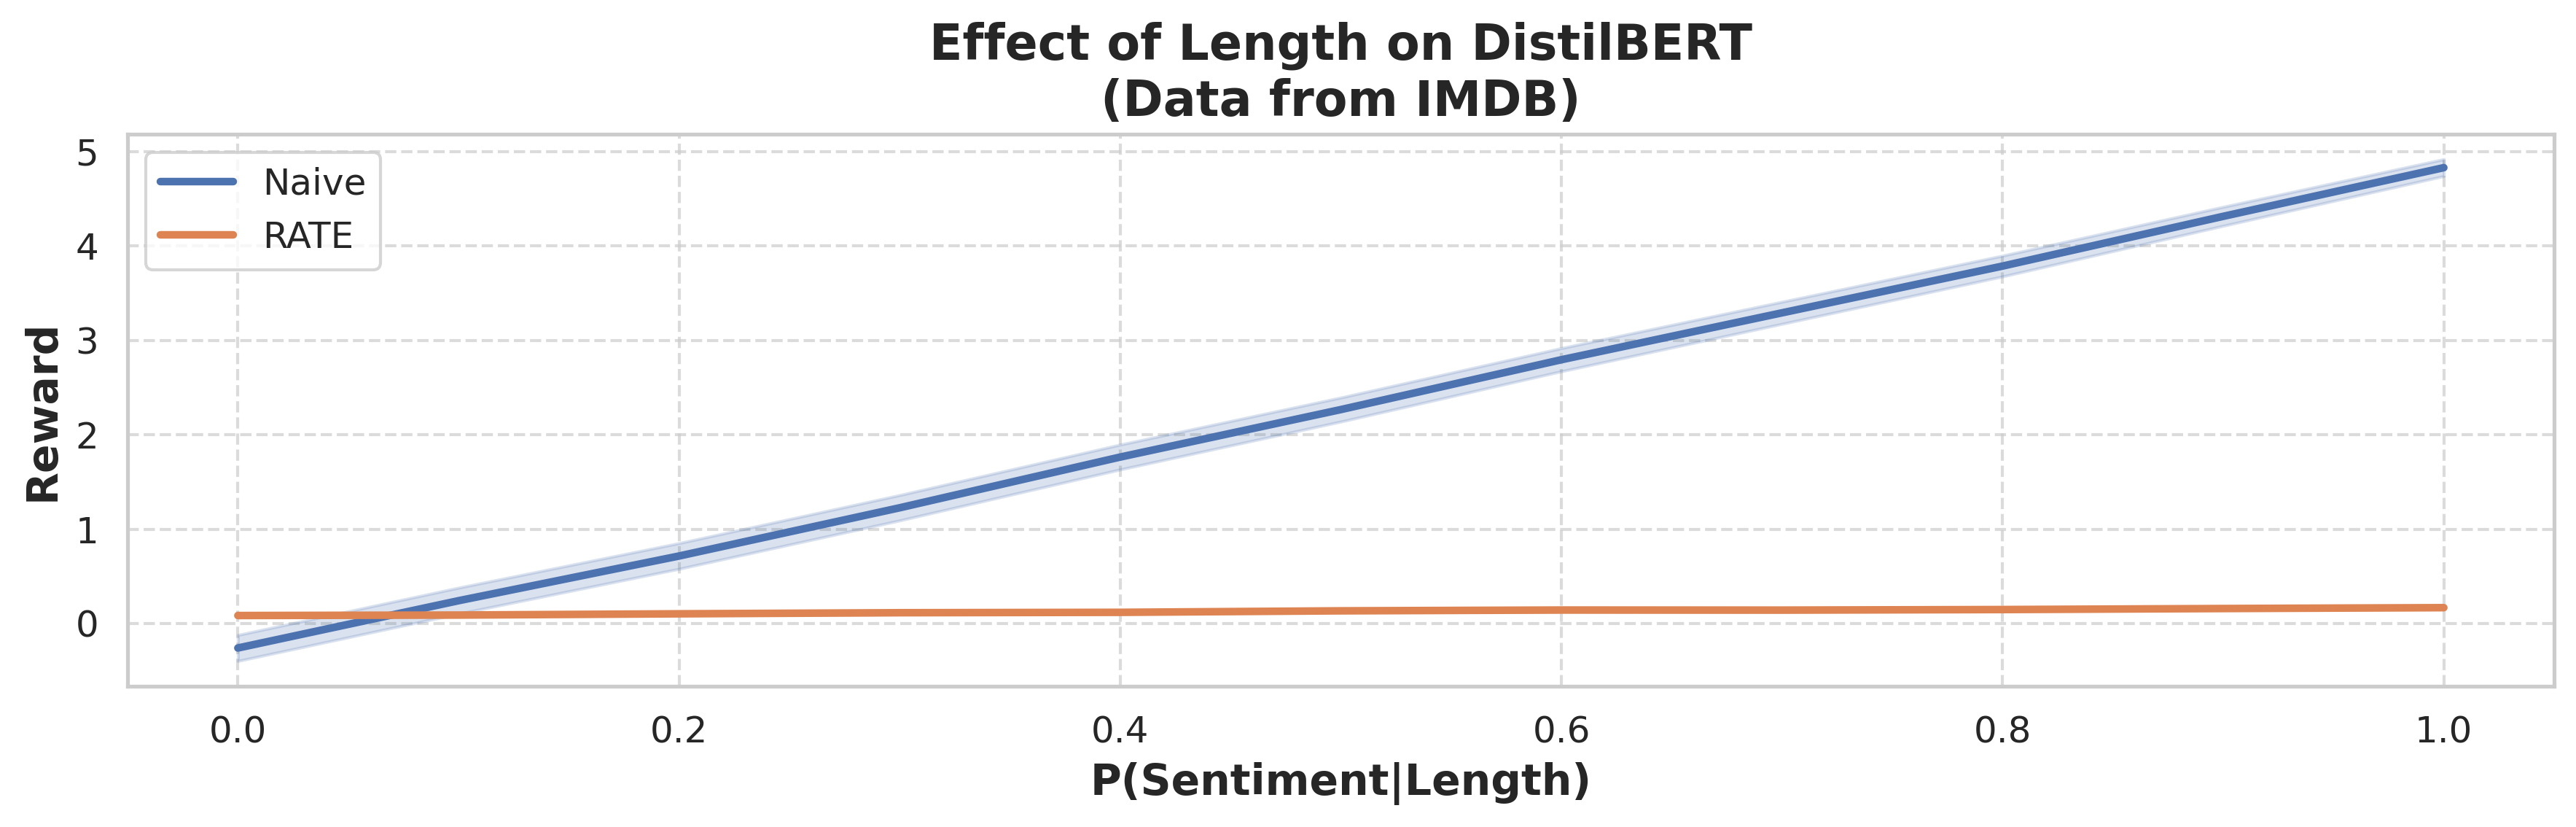

In [15]:
synthetic(synthetic_data, synthetic_templates, "Length", "Sentiment")

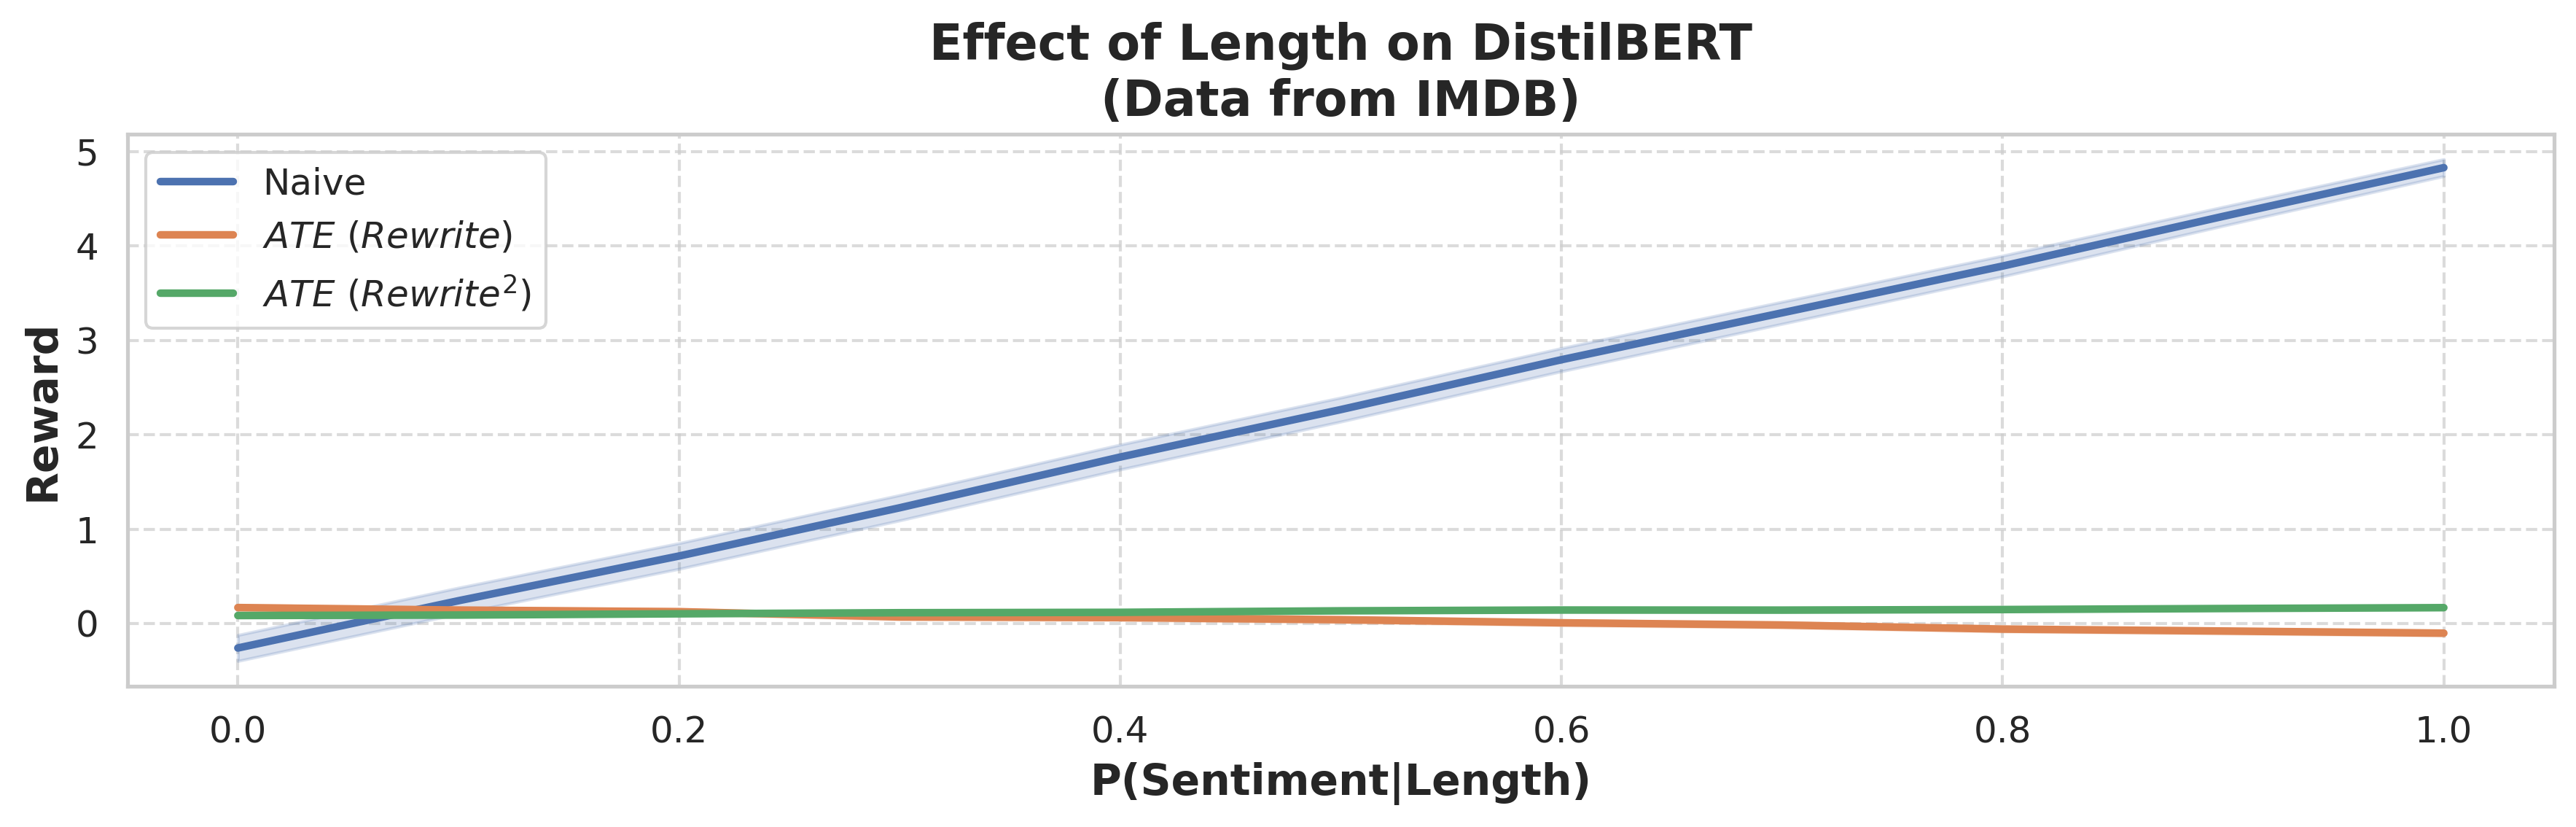

In [16]:
synthetic_3way(synthetic_data, synthetic_templates, "Length", "Sentiment")

In [17]:
help_synthetic_templates = [
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": f"synthetic_helpsteer_base_correlated_{i}.jsonl"
    } for i in range(11)
    ]

In [18]:
# save all the data
help_synthetic_data = []
for effects_template in help_synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic_helpsteer" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    help_synthetic_data.append(effects)

2024-10-02 00:08:43,387 - INFO - Number of w=1 examples: 2574
2024-10-02 00:08:43,388 - INFO - Number of w=0 examples: 2574
2024-10-02 00:08:43,410 - INFO - Treatment effects: {   'ATE': 0.014393984818637143,
    'ATE_naive': 0.01957111698185457,
    'ATE_stderr': 0.0003646353423113441,
    'ATE_stderr_naive': 0.0005043422673346951,
    'ATT': 0.0054083771461102825,
    'ATT_naive': 0.04116395636899113,
    'ATT_stderr': 0.0011309362696518663,
    'ATT_stderr_naive': 0.0009968333851053208,
    'ATU': 0.02337959249116403,
    'ATU_naive': -0.002021722405281992,
    'ATU_stderr': 0.0010911649065769267,
    'ATU_stderr_naive': 0.001127463717047579,
    'naive_effect': 0.02154123385671293,
    'naive_effect_naive': 0.031895498183147755,
    'naive_effect_stderr': 0.0010809832609582038,
    'naive_effect_stderr_naive': 0.000981691571743384}
2024-10-02 00:08:43,411 - INFO - Calculated ATE (from ATT and ATU): 0.014393984818637157
2024-10-02 00:08:43,415 - INFO - Rewrite effects: {   'rewrite_

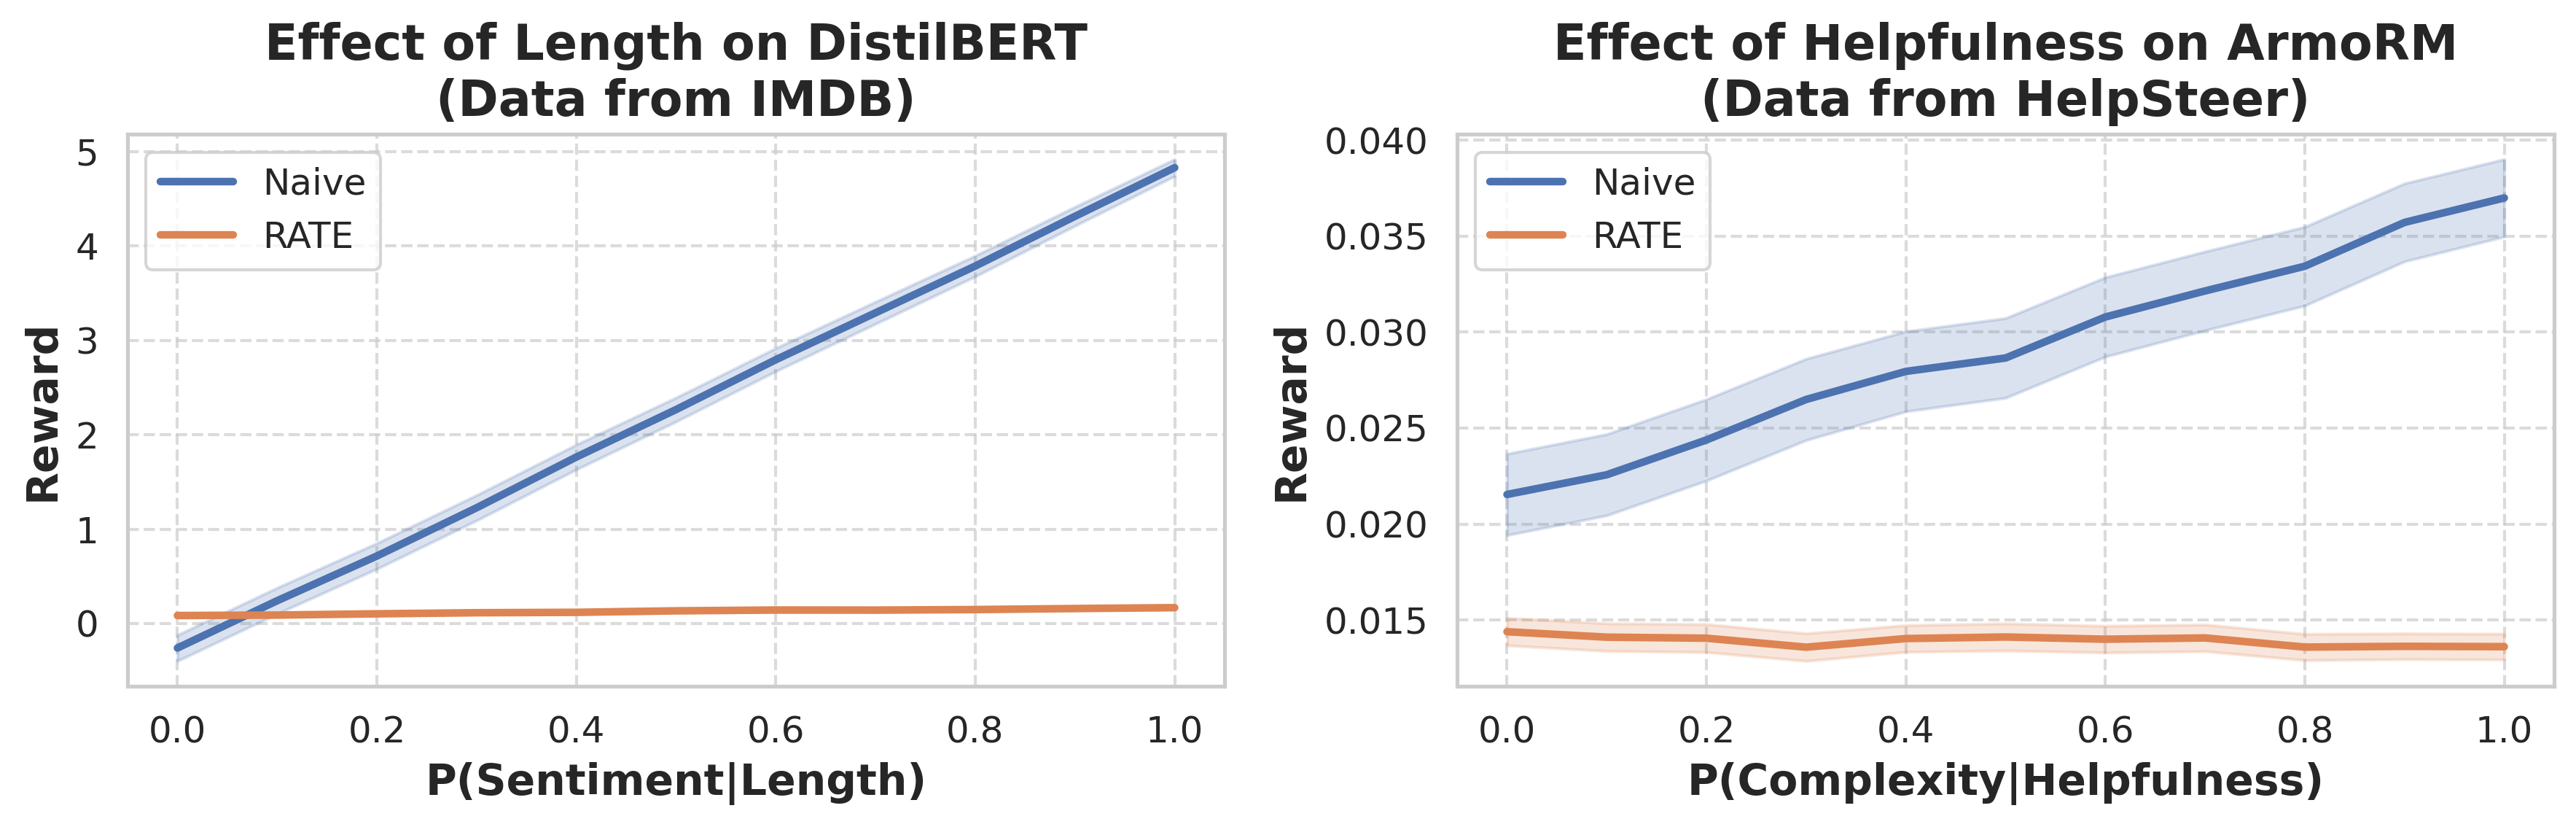

In [19]:
synthetic_subplots(synthetic_data, synthetic_templates, "Length", "Sentiment",
          help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity")

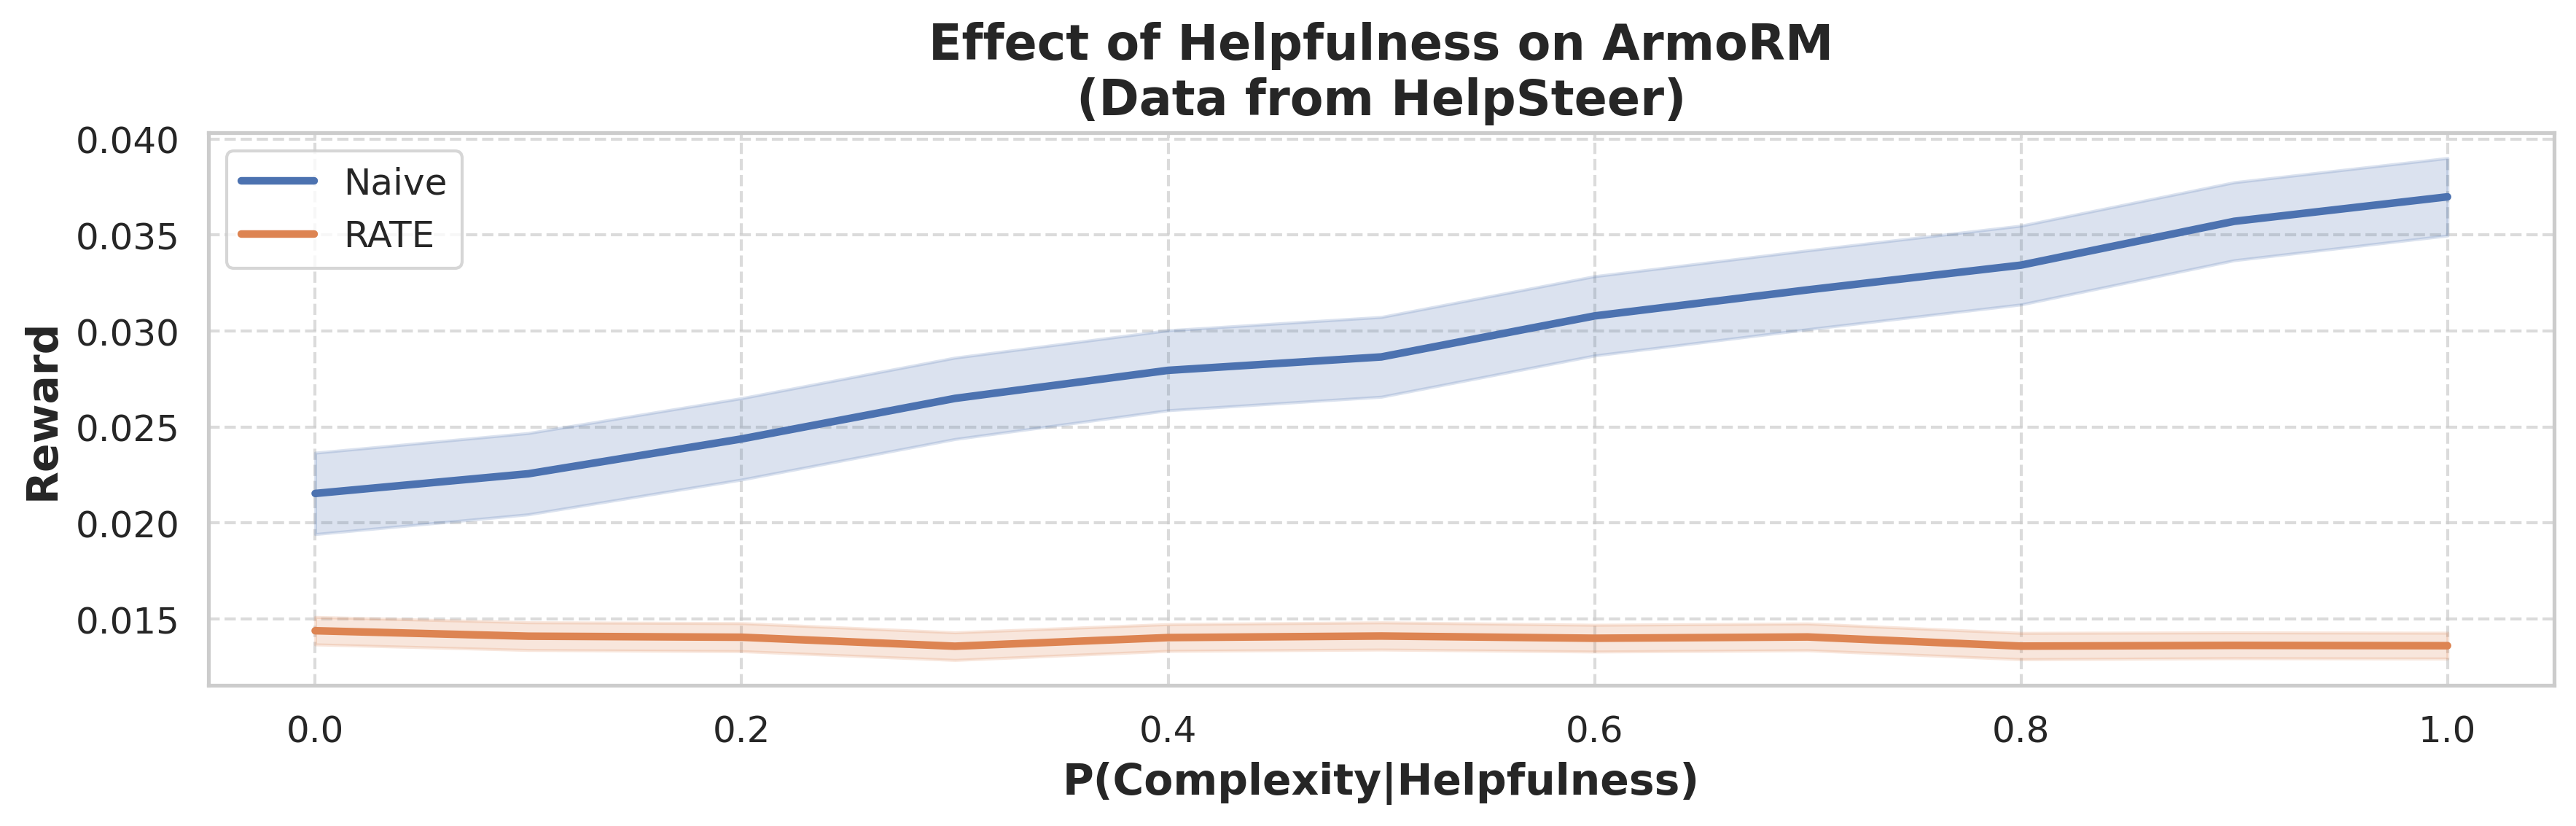

In [20]:
synthetic(help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity")

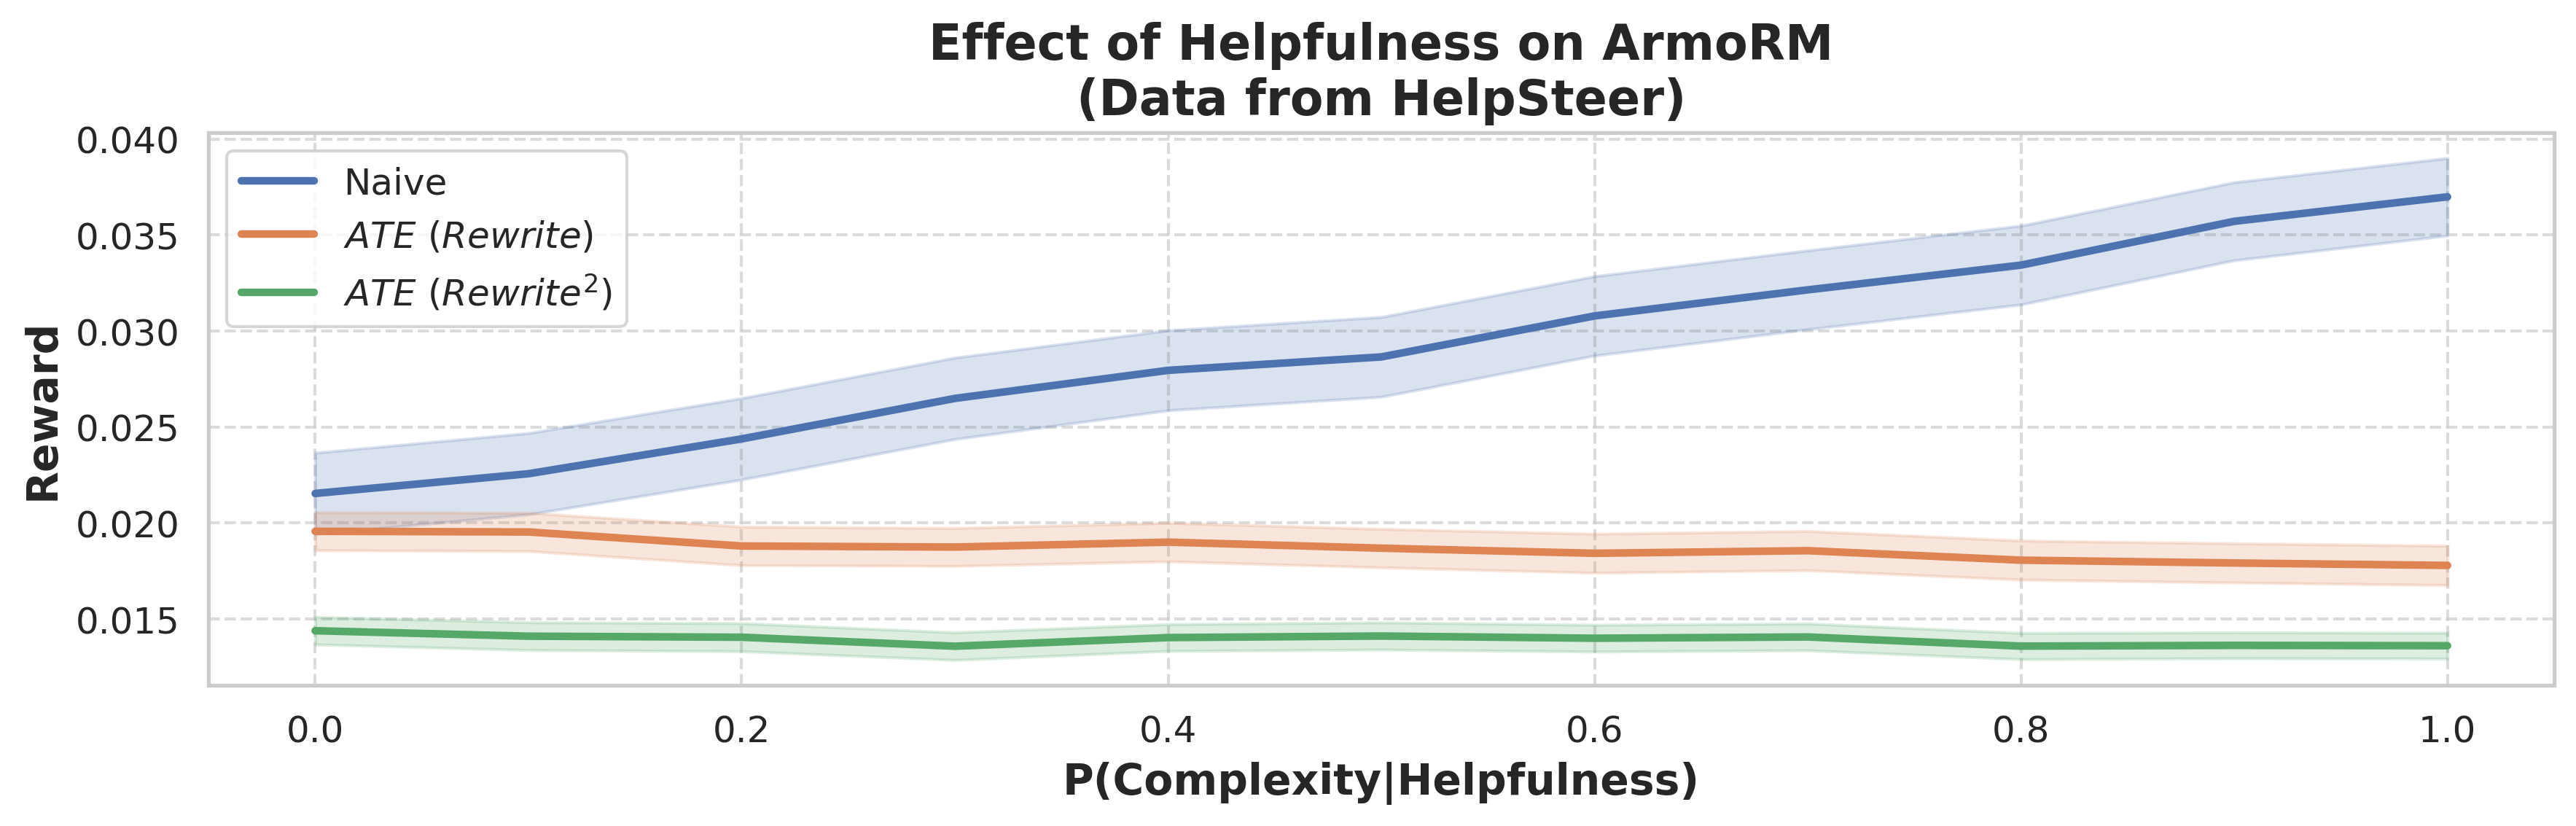

In [21]:
synthetic_3way(help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity")